In [1]:
from RobustGibbsObject import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

- Normaliser les summary stats dans ABC par leur var
- Quantiles ABC galere modele mal specifié + y a de quantile + il galere
- Cauchy comme Model C ou loi asym 
- Verif en faisant plusieurs essaie de Bridge 

- Normal / LogExp : Quartiles 1 et 3 
- Real data: Data - min puis log -> Normal/Laplace ou student ou GPD 
- Quantile fixés : boxplot
- Normal/ Laplace: 
- Unif/Beta : 
- NORMAL / LAPLACE + MAL SPECIFIE POISSON (OVERLAP?)
- NEGBIN / POISSON : ESTIM
- REAL DATA (OVERLAP? SUPPORT? PARAMETERS?)


In [2]:
def display(dico,burnin=0,true_par=[]):
    par_names = list(dico["chains"].keys())
    
    f,ax= plt.subplots(2,len(par_names),figsize=(20,10))
    for i,par_name in enumerate(par_names):
        ax[0,i].plot(dico["chains"][par_name][burnin:])
        ax[0,i].set_title(par_name)
        sns.kdeplot(dico["chains"][par_name][burnin:],ax=ax[1,i])
        if true_par!=[]:
            ax[0,i].axhline(true_par[i],color="red")
            ax[1,i].axvline(true_par[i],color="red")
    plt.show()

In [3]:
from RobustGibbsObject.Distribution import Normal,Laplace,Gamma,InverseGamma
from RobustGibbsObject.Model import NormalModel,LaplaceModel, ReparametrizedLaplaceModel


# Bridge


In [4]:

from scipy.optimize import fixed_point
from scipy.special import logsumexp
def func_logBF_logsumexp(logBF,lratio_num,lratio_den):
    num_j = np.array([logsumexp([0,logBF+lratio_num[j]]) for j in range(len(lratio_num))])
    den_i = np.array([logsumexp([lratio_den[i],logBF]) for i in range(len(lratio_den))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den

def logBF_logsumexp_fixedpoint(lratio_num,lratio_den):
    return fixed_point(func_logBF_logsumexp,0,args=(lratio_num,lratio_den))

In [5]:
from scipy.special import logsumexp
def logBF_Bridge_ratio(lratio_num, lratio_den,BF_init = 0, epsilon=0, a=0, n_iter = 10000, verbose = True):
    logBF = [np.inf,BF_init]
    n = min(len(lratio_num),len(lratio_den))
    k=0
    while np.abs(logBF[-1]-logBF[-2])>epsilon and k<n_iter:

        num_j = np.array([logsumexp([0,logBF[-1]+lratio_num[j]]) for j in range(n)])
        den_i = np.array([logsumexp([lratio_den[i],logBF[-1]]) for i in range(n)])
        
        num = logsumexp(-num_j)
        den = logsumexp(-den_i)

        new_logBF = num-den
        logBF.append(new_logBF)
        k+=1
        
        if verbose:print("Iteration {}: log(numerator) = {}, log(denominator) = {}, logBF = {}\n\n".format(k,num,den,new_logBF))
        
    return logBF[1:]

In [6]:
def func_r_paper(r,l1,l2,lstar):
    lstar = np.median(l1)
    return np.sum(np.exp(l2-lstar)/(np.exp(l2-lstar)+r))/np.sum(1/(np.exp(l1-lstar)+r))


def BF_paper(l1,l2):
    lstar = np.median(l1)
    r = fixed_point(func_r_paper,np.exp(-lstar),args=(l1,l2,lstar))
    BF = r*np.exp(lstar)
    return BF

def func_r_paper2(logBF,l1,l2):
    num_j = np.array([logsumexp([0,logBF-l2[j]]) for j in range(len(l2))])
    den_i = np.array([logsumexp([l1[i],logBF]) for i in range(len(l1))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den


def logBF_paper(l1,l2):
    logBF = fixed_point(func_r_paper2,0,args=(l1,l2),maxiter=1000)
    return logBF

In [7]:
def log_ratio_normal_laplace(X,mu):
    return -(N/2)*np.log(np.pi)+np.sqrt(2)*np.sum(np.abs(X-mu))-np.sum((X-mu)**2)/2

# ABC Model Choice

In [8]:
def ABC_Model(T,N,med,MAD,epsilon):
    M = []
    Eta = []
    Theta = []
    Y = []
    eta_obs = np.array([med,MAD])
    for t in tqdm(range(T)):
        dist = epsilon+1
        while dist>epsilon:
            mean = np.random.normal(0,5,1)
            std = invgamma.rvs(1,1,1)
            if np.random.uniform()<0.5:
                y = np.random.normal(mean,std,N)
                m = 1
            else: 
                y = np.random.laplace(mean,std/np.sqrt(2),N)
                m = 2
            eta_sim = np.array([np.median(y),np.median(np.abs(y-np.median(y)))])
            var_sim = np.var(eta_sim,axis=0)
            dist = np.sum(((eta_obs-eta_sim)/varsim)**2)

        M.append(m)
        Theta.append([mean,std])
        Eta.append(eta_sim)
        Y.append(y)
    return {"M":np.array(M),"Theta":np.array(Theta),"Y":np.array(Y), "Eta":np.array(Eta)}
        
        

In [8]:
def ABC_Model_Paper(T,N,med,MAD,eps=.01):
    eta_obs = np.array([med,MAD])
    mean = np.random.normal(0,2,T)
    std = 1
    y_norm = norm(loc = mean[:T//2],scale = std).rvs([N,T//2]).T
    y_laplace =laplace(loc = mean[T//2:], scale = std/np.sqrt(2)).rvs([N,T//2]).T
    y = np.concatenate([y_norm,y_laplace],axis=0)
    eta_sim = np.array([np.median(y,axis=1),median_abs_deviation(y,axis=1)]).T
    dist = np.sum(((eta_obs-eta_sim)/np.std(eta_sim,axis=0))**2,axis=1)
    
    epsilon = np.quantile(dist,eps)
    idx = np.where(dist<epsilon)[0]
    model1 = len(idx[idx<T//2])
    model2 = len(idx[idx>=T//2])
    if model2 == 0:
        BF = np.inf
    else:
        BF = model1/model2    
    return {"Y":y,"eta_sim":eta_sim,"dist":dist,"BF":BF,"Proba1": model1/len(idx)}
        
        

# Comparison

In [9]:
from RobustGibbsObject.Model import NormalKnownScaleModel, LaplaceKnownScaleModel
from RobustGibbsObject.Distribution import Normal, Laplace


In [10]:
def Comparison(N,T):
    X_norm = np.random.normal(0,1,N)
    X_laplace = np.random.laplace(0,1/np.sqrt(2),N)
    X_cauchy = np.random.standard_cauchy(N)
    L_Bridge = []
    L_logBridge = []
    L_ABC = []
    eps =.01
    for X in [X_norm,X_laplace,X_cauchy]:
        med, MAD = np.median(X),median_abs_deviation(X)

        ABC_BF = ABC_Model_Paper(T,N,med,MAD,eps)["BF"]
        L_ABC.append(ABC_BF)
        MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med,MAD,List_X = True,verbose=False)
        MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med,MAD,List_X = True,verbose=False)
        X_Normal,X_Laplace = np.array(MCMC_norm["X"][1:]),np.array(MCMC_laplace["X"][1:])
        mu_Normal, mu_Laplace= np.array(MCMC_norm["chains"]["loc"]),np.array(MCMC_laplace["chains"]["loc"])
        
        l1 = [log_ratio_normal_laplace(X,mu) for X,mu in zip(X_Normal,mu_Normal)]
        l2 = [log_ratio_normal_laplace(X,mu) for X,mu in zip(X_Laplace,mu_Laplace)]
        
        BF_bridge = BF_paper(l1,l2)
        logBF_bridge = logBF_paper(l1,l2)
        
        L_Bridge.append(BF_bridge)
        L_logBridge.append(logBF_bridge)
    return [L_Bridge,L_logBridge,L_ABC]
    
        
        
        

In [297]:
res.shape

(5, 3, 3)

In [12]:
N_list = [101,1001]
T = 10000

n_iter = 100
# Normal_Bridge_N, Normal_logBridge_N, Normal_ABC_N = [],[],[]
# Laplace_Bridge_N, Laplace_logBridge_N, Laplace_ABC_N = [],[],[]
# Cauchy_Bridge_N, Cauchy_logBridge_N, Cauchy_ABC_N = [],[],[]
for N in N_list:
    print("N = {}".format(N))
    res = [Comparison(N,T) for _ in tqdm(range(n_iter))]
    res = np.array(res)
    Normal_Bridge_N.append(res[:,0,0])
    Normal_logBridge_N.append(res[:,1,0])
    Normal_ABC_N.append(res[:,2,0])
    Laplace_Bridge_N.append(res[:,0,1])
    Laplace_logBridge_N.append(res[:,1,1])
    Laplace_ABC_N.append(res[:,2,1])
    Cauchy_Bridge_N.append(res[:,0,2])
    Cauchy_logBridge_N.append(res[:,1,2])
    Cauchy_ABC_N.append(res[:,2,2])
    
    

N = 101


100%|██████████| 100/100 [1:32:20<00:00, 55.40s/it]


N = 1001


100%|██████████| 100/100 [1:37:05<00:00, 58.25s/it]


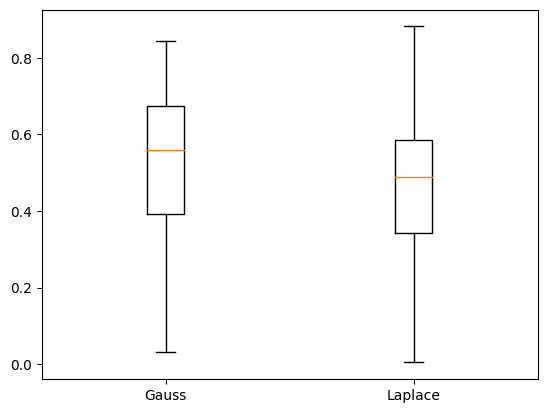

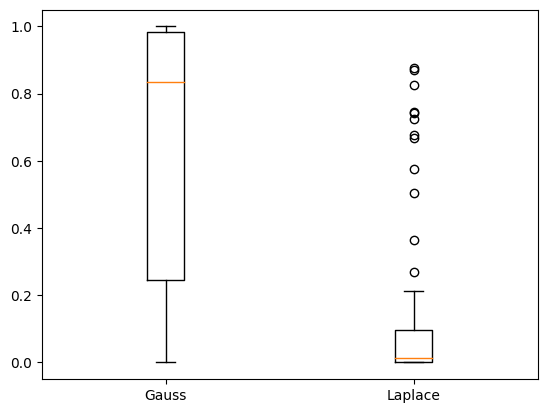

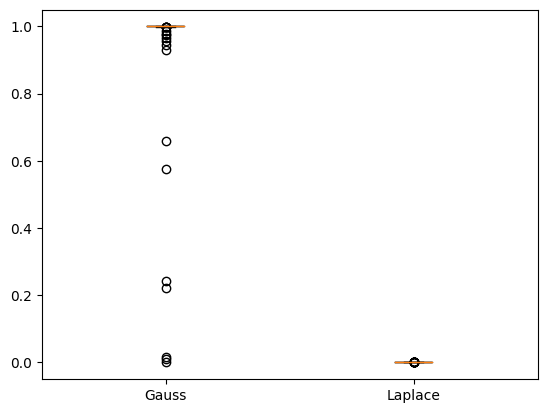

In [58]:
Normal_Bridge_N = np.array(Normal_Bridge_N)
Laplace_Bridge_N = np.array(Laplace_Bridge_N)
for i in range(3):
    plt.boxplot([Normal_Bridge_N[i]/(Normal_Bridge_N[i]+1),Laplace_Bridge_N[i]/(Laplace_Bridge_N[i]+1)],labels=["Gauss","Laplace"])
    plt.show()

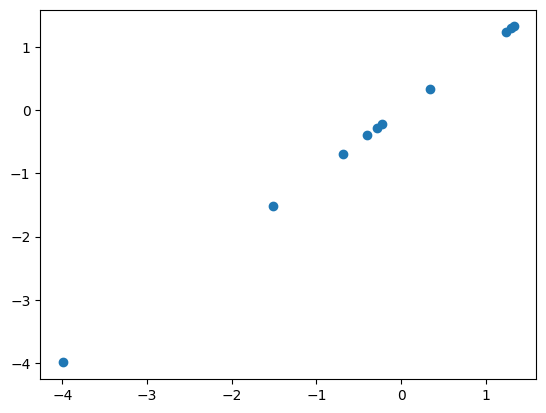

In [19]:
plt.scatter(np.log(Normal_Bridge_N[0]),Normal_logBridge_N[0])

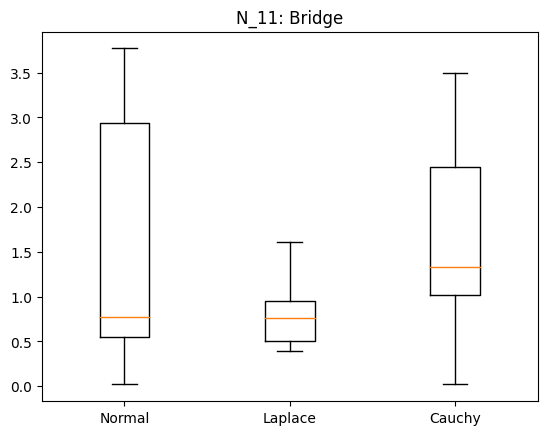

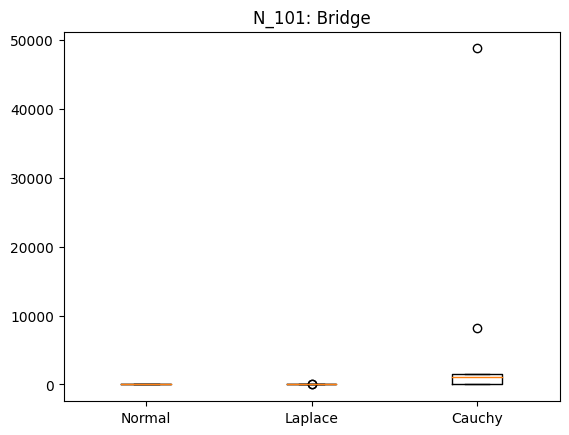

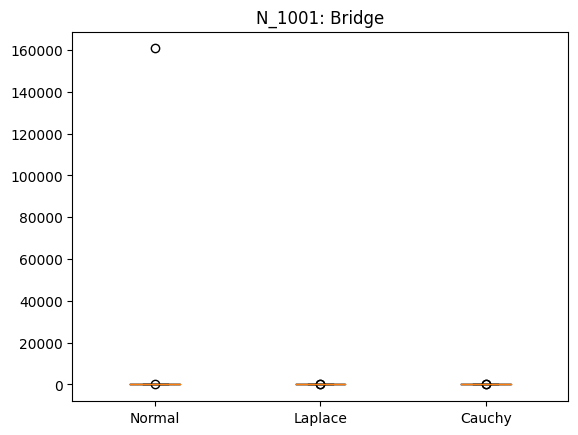

In [18]:
for i,N in enumerate(N_list):
    plt.boxplot([Normal_Bridge_N[i],Laplace_Bridge_N[i],Cauchy_Bridge_N[i]],labels = ["Normal","Laplace","Cauchy"])
    plt.title("N_{}: Bridge".format(N))
    plt.show()

In [27]:
BF_norm = []
P_norm = []
BF_norm2 = []
P_norm2 = []
for N in [10,100,1000]:
      P_N = []
      BF_N = []
      P_N2 = []
      BF_N2 = []
      for x in tqdm(range(50)):
            X = np.random.normal(0,1,N)
            med,MAD = np.median(X),median_abs_deviation(X)
            ABC_paper = ABC_Model_Paper(10000,N,med,MAD)
            ABC_paper2 = ABC_Model_Paper2(10000,N,med,MAD)
            P_N.append(ABC_paper["Proba1"])
            BF_N.append(ABC_paper["BF"])
            P_N2.append(ABC_paper2["Proba1"])
            BF_N2.append(ABC_paper2["BF"])
      P_norm2.append(P_N2)
      BF_norm2.append(BF_N2)
      P_norm.append(P_N)
      BF_norm.append(BF_N)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:11<00:00,  1.42s/it]


In [28]:
BF_laplace = []
P_laplace = []
BF_laplace2 = []
P_laplace2 = []
for N in [10,100,1000]:
      P_N = []
      BF_N = []
      P_N2 = []
      BF_N2 = []
      for x in tqdm(range(50)):
            X = np.random.laplace(0,1/np.sqrt(2),N)
            med,MAD = np.median(X),median_abs_deviation(X)
            ABC_paper = ABC_Model_Paper(10000,N,med,MAD)
            ABC_paper2 = ABC_Model_Paper2(10000,N,med,MAD)
            P_N2.append(ABC_paper2["Proba1"])
            BF_N2.append(ABC_paper2["BF"])
      
            BF_N.append(ABC_paper["BF"])
            P_N.append(ABC_paper["Proba1"])
      P_laplace.append(P_N)
      BF_laplace.append(BF_N)
      P_laplace2.append(P_N2)
      BF_laplace2.append(BF_N2)
      

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


## Paper $\theta = \mu$

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


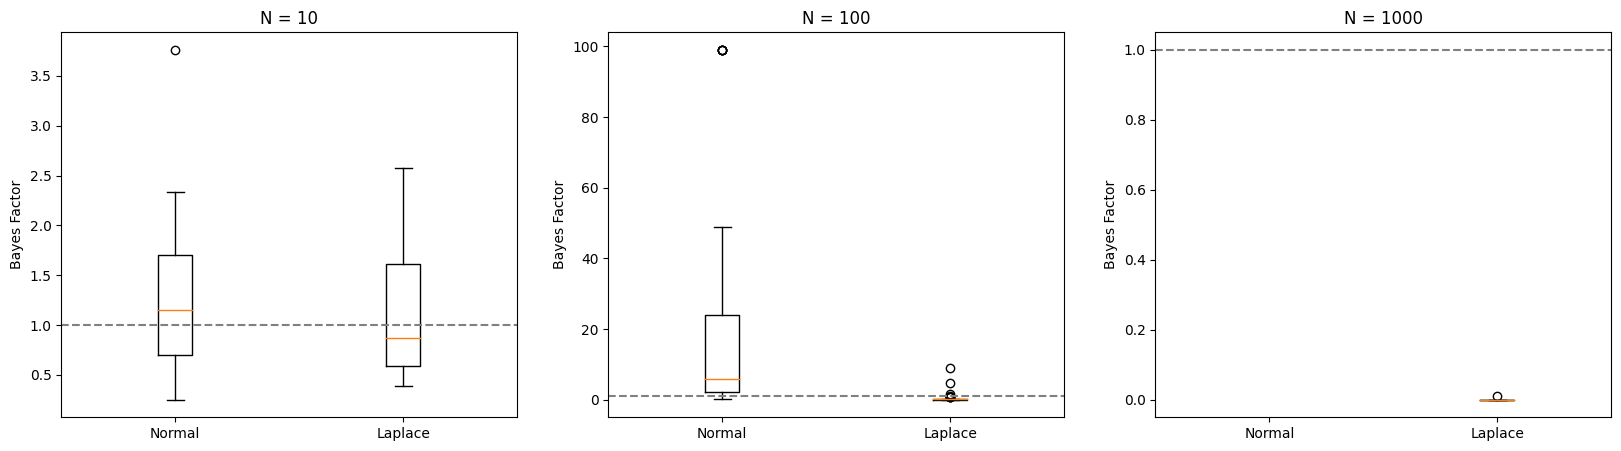

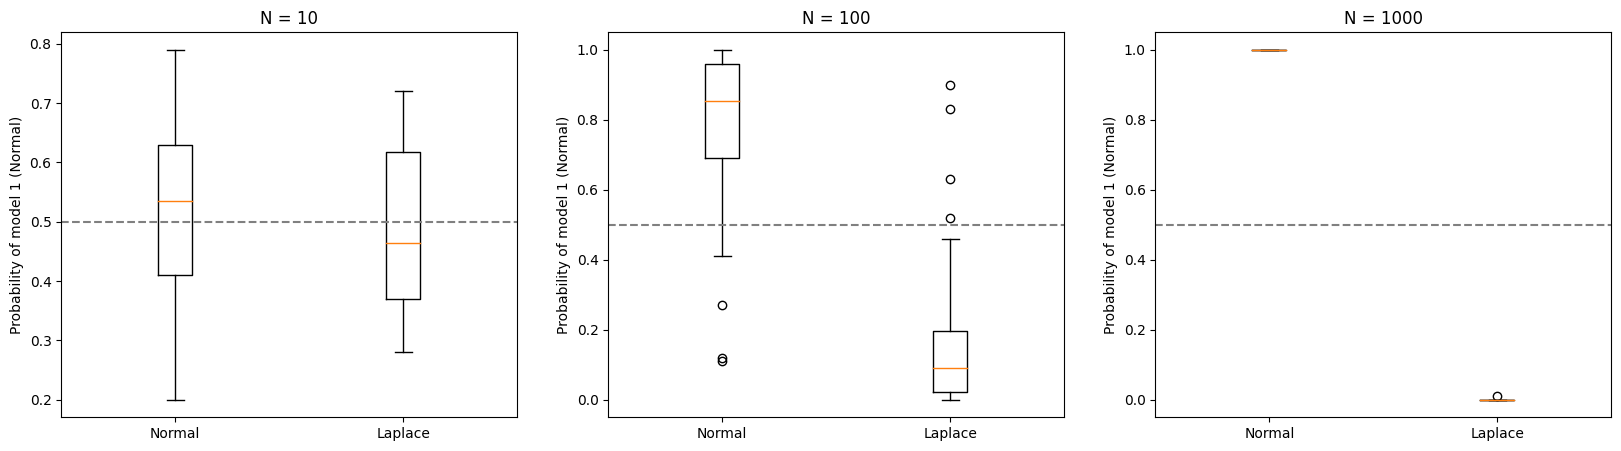

In [29]:
f,ax = plt.subplots(1,3,figsize=(20,5))
for i,N in enumerate([10,100,1000]):
    ax[i].boxplot([BF_norm[i],BF_laplace[i]],labels=["Normal","Laplace"])
    ax[i].set_title("N = {}".format(N))
    ax[i].axhline(1,color="grey",linestyle="--")
    ax[i].set_ylabel("Bayes Factor")
plt.show()
f,ax = plt.subplots(1,3,figsize=(20,5))
for i,N in enumerate([10,100,1000]):
    ax[i].boxplot([P_norm[i],P_laplace[i]],labels=["Normal","Laplace"])
    ax[i].set_title("N = {}".format(N))
    ax[i].axhline(.5,color="grey",linestyle="--")
    ax[i].set_ylabel("Probability of model 1 (Normal)")
plt.show()

## New $\theta = (\mu, \sigma)$

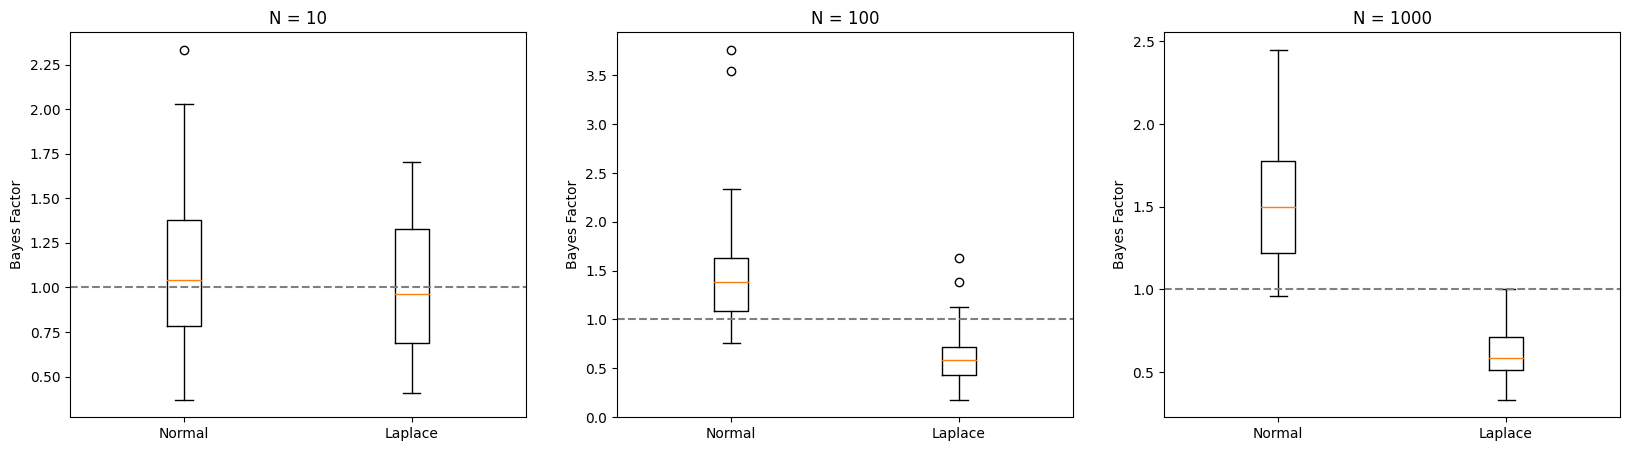

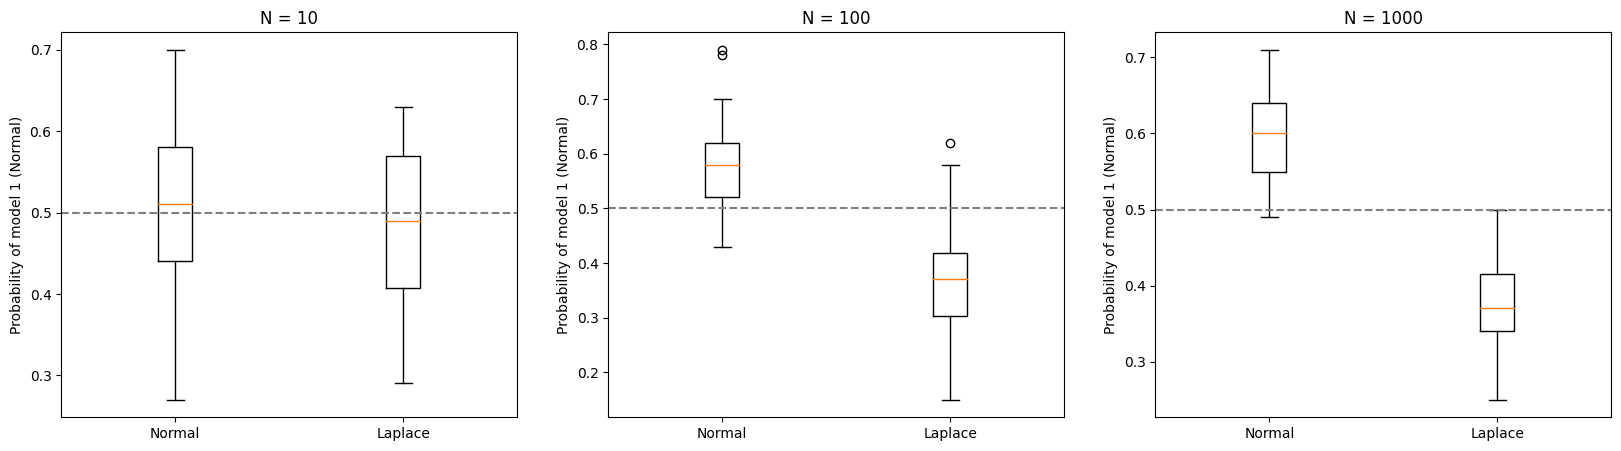

In [30]:
f,ax = plt.subplots(1,3,figsize=(20,5))
for i,N in enumerate([10,100,1000]):
    ax[i].boxplot([BF_norm2[i],BF_laplace2[i]],labels=["Normal","Laplace"])
    ax[i].set_title("N = {}".format(N))
    ax[i].axhline(1,color="grey",linestyle="--")
    ax[i].set_ylabel("Bayes Factor")
plt.show()
f,ax = plt.subplots(1,3,figsize=(20,5))
for i,N in enumerate([10,100,1000]):
    ax[i].boxplot([P_norm2[i],P_laplace2[i]],labels=["Normal","Laplace"])
    ax[i].set_title("N = {}".format(N))
    ax[i].axhline(.5,color="grey",linestyle="--")
    ax[i].set_ylabel("Probability of model 1 (Normal)")
plt.show()

# Bridge Paper


In [6]:
from RobustGibbsObject.Model import NormalKnownScaleModel, LaplaceKnownScaleModel
from RobustGibbsObject.Distribution import Normal, Laplace, InverseGamma, Gamma

In [197]:
# ABC_norm2 = []
# Bridge_norm2 = []
N = 201
T = 10000
LBF2 = []
for _ in tqdm(range(10)):
    X_norm = np.random.normal(0,1,N)
    med_norm,MAD_norm = np.median(X_norm),median_abs_deviation(X_norm)
    BF_ABC = ABC_Model_Paper(T,N,med_norm,MAD_norm)["BF"]
    while BF_ABC==np.inf:
        print("Inf")
        BF_ABC = ABC_Model_Paper(T,N,med_norm,MAD_norm)["BF"]
    ABC_norm2.append(BF_ABC)
    MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_norm,MAD_norm,List_X = True,verbose=False)
    MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_norm,MAD_norm,List_X = True,verbose=False)
    X_Normal = np.array(MCMC_norm["X"][1:])
    X_Laplace = np.array(MCMC_laplace["X"][1:])
    mu_Normal = np.array(MCMC_norm["chains"]["loc"])
    mu_Laplace = np.array(MCMC_laplace["chains"]["loc"])
    ratio_num = -np.array([log_ratio_normal_laplace(X_Laplace[i],mu_Laplace[i]) for i in range(len(X_Laplace))])
    ratio_den = np.array([log_ratio_normal_laplace(X_Normal[i],mu_Normal[i]) for i in range(len(X_Normal))])
    print("Bridge...",end="")
    logBF_bridge = logBF_Bridge_ratio(ratio_num,ratio_den,BF_init = 1, epsilon=0.1, a=0, n_iter = 1000, verbose = False)
    Bridge_norm2.append(logBF_bridge[-1])
    LBF2.append(logBF_bridge)
    print("Done! Bridge = {} ABC = {}".format(Bridge_norm2[-1],np.log(ABC_norm2[-1])))

  0%|          | 0/10 [00:00<?, ?it/s]

Bridge...

 10%|█         | 1/10 [02:58<26:45, 178.34s/it]

Done! Bridge = 2.248274438278812 ABC = 4.59511985013459
Bridge...

 20%|██        | 2/10 [05:55<23:41, 177.70s/it]

Done! Bridge = 1.6439892955723776 ABC = 2.0907410969337694
Bridge...

 30%|███       | 3/10 [08:52<20:40, 177.28s/it]

Done! Bridge = 5.161703218875893 ABC = 3.1780538303479458
Bridge...

 40%|████      | 4/10 [11:49<17:43, 177.31s/it]

Done! Bridge = -0.1007734573057375 ABC = 2.751535313041949
Inf
Inf
Inf
Inf
Inf
Inf
Inf
Inf
Inf
Inf
Inf
Inf
Inf
Bridge...

 50%|█████     | 5/10 [12:15<10:13, 122.74s/it]

Done! Bridge = 8.19259552221064 ABC = 4.59511985013459
Bridge...

 60%|██████    | 6/10 [12:56<06:19, 94.83s/it] 

Done! Bridge = 8.865784836103026 ABC = 4.59511985013459
Bridge...

 70%|███████   | 7/10 [15:54<06:06, 122.04s/it]

Done! Bridge = -0.27641207632389797 ABC = 2.1972245773362196
Inf
Bridge...

 80%|████████  | 8/10 [18:52<04:40, 140.00s/it]

Done! Bridge = 1.4057586553414803 ABC = 4.59511985013459
Bridge...

 90%|█████████ | 9/10 [21:50<02:31, 151.76s/it]

Done! Bridge = 1.1621950642895298 ABC = 4.59511985013459
Inf
Inf
Inf
Inf
Inf
Bridge...

100%|██████████| 10/10 [24:48<00:00, 148.82s/it]

Done! Bridge = 9.703579527639643 ABC = 4.59511985013459


In [196]:
Bridge_norm2, np.log(ABC_norm2)

([10.750293474198854,
  4.064481603434927,
  -2.708400426802673,
  0.12213215994559512,
  5.75807098742929,
  12.811152063514648,
  1.5536561216038702,
  -1.8619881824111673,
  0.932719875162114,
  0.8233413771992453],
 array([       inf, 1.32492541, 3.8918203 ,        inf, 2.19722458,
               inf,        inf, 2.58668934, 4.59511985, 3.8918203 ]))

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe379947110>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe36bcf6290>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe379e3d490>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe36bce9710>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe36bd20ad0>,
 'means': []}

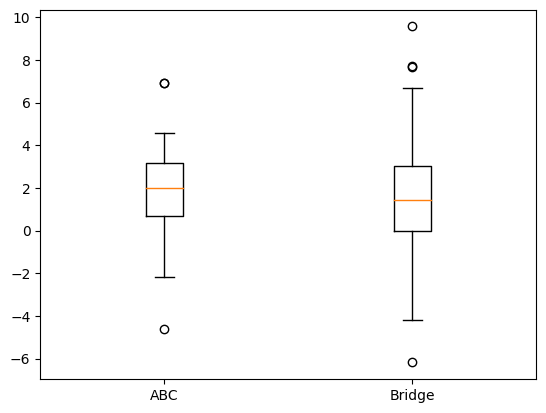

In [186]:
np.log(ABC_norm), np.log(Bridge_norm)
plt.boxplot([np.log(ABC_norm),(Bridge_norm)],labels=["ABC","Bridge"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe36bde7a50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe36c916590>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe359de1850>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe36c916c90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe36c8b1fd0>,
 'means': []}

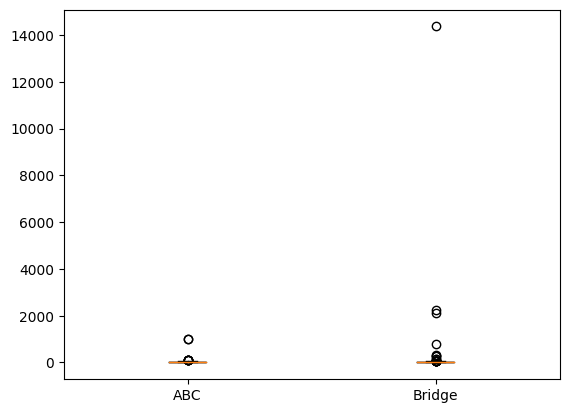

In [187]:
plt.boxplot([ABC_norm,np.exp(Bridge_norm)],labels=["ABC","Bridge"])

In [199]:
# ABC_lp = []
# Bridge_lp = []
N = 101
T = 10000
LBF_lp = []
for _ in tqdm(range(90)):
    X_lp = np.random.laplace(0,1/np.sqrt(2),N)
    med_lp,MAD_lp = np.median(X_lp),median_abs_deviation(X_lp)
    ABC_lp.append(ABC_Model_Paper(T,N,med_lp,MAD_lp)["BF"])
    MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_lp,MAD_lp,List_X = True,verbose=False)
    MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_lp,MAD_lp,List_X = True,verbose=False)
    X_Normal = np.array(MCMC_norm["X"][1:])
    X_Laplace = np.array(MCMC_laplace["X"][1:])
    mu_Normal = np.array(MCMC_norm["chains"]["loc"])
    mu_Laplace = np.array(MCMC_laplace["chains"]["loc"])
    ratio_num = -np.array([log_ratio_normal_laplace(X_Laplace[i],mu_Laplace[i]) for i in range(len(X_Laplace))])
    ratio_den = np.array([log_ratio_normal_laplace(X_Normal[i],mu_Normal[i]) for i in range(len(X_Normal))])
    print("Bridge...",end="")
    logBF_bridge = logBF_Bridge_ratio(ratio_num,ratio_den,BF_init = 1, epsilon=0.1, a=0, n_iter = 100, verbose = False)
    # if np.abs(logBF_bridge[-1]-logBF_bridge[-2])>0.1:
    #     Bridge_norm.append((logBF_bridge[-1]+logBF_bridge[-2])/2)
    Bridge_lp.append(logBF_bridge[-1])
    LBF_lp.append(logBF_bridge)
    print("Done! Bridge = {} ABC = {}".format(Bridge_lp[-1],np.log(ABC_lp[-1])))

  0%|          | 0/90 [00:00<?, ?it/s]

Bridge...

  1%|          | 1/90 [00:24<35:42, 24.07s/it]

Done! Bridge = -0.6247359997385704 ABC = -2.4423470353692043
Bridge...

  2%|▏         | 2/90 [01:02<47:59, 32.72s/it]

Done! Bridge = -5.541216626002934 ABC = -0.40546510810816444
Bridge...

  3%|▎         | 3/90 [01:41<51:16, 35.36s/it]

Done! Bridge = -6.208718391576941 ABC = -2.9444389791664407
Bridge...

  4%|▍         | 4/90 [02:07<45:12, 31.54s/it]

Done! Bridge = -4.95638540143485 ABC = -3.891820298110627
Bridge...

  6%|▌         | 5/90 [02:34<42:47, 30.21s/it]

Done! Bridge = -9.093098772339584 ABC = -4.59511985013459
Bridge...

  7%|▋         | 6/90 [03:00<40:04, 28.62s/it]

Done! Bridge = 3.8139880553770125 ABC = -0.08004270767353637
Bridge...

  8%|▊         | 7/90 [03:38<44:02, 31.83s/it]

Done! Bridge = -1.7178431451675085 ABC = -2.5866893440979424
Bridge...

  9%|▉         | 8/90 [04:04<40:51, 29.90s/it]

Done! Bridge = -1.4159148638973464 ABC = 0.5322168137473082
Bridge...

 10%|█         | 9/90 [04:28<37:40, 27.91s/it]

Done! Bridge = -2.955706363107101 ABC = -2.5866893440979424
Bridge...

 11%|█         | 10/90 [04:54<36:31, 27.40s/it]

Done! Bridge = -3.8856380935993 ABC = -2.4423470353692043
Bridge...

 12%|█▏        | 11/90 [05:24<37:12, 28.26s/it]

Done! Bridge = -0.07370399022377416 ABC = 1.0986122886681098
Bridge...

 13%|█▎        | 12/90 [06:03<40:46, 31.37s/it]

Done! Bridge = -9.096529930804564 ABC = -3.4760986898352733
Bridge...

 14%|█▍        | 13/90 [06:28<38:01, 29.63s/it]

Done! Bridge = -3.0374656876363426 ABC = 0.322773392263051
Bridge...

 16%|█▌        | 14/90 [06:59<38:09, 30.12s/it]

Done! Bridge = -7.787723631836134 ABC = -4.59511985013459
Bridge...

 17%|█▋        | 15/90 [07:24<35:25, 28.34s/it]

Done! Bridge = -5.045246302898602 ABC = -2.751535313041949
Bridge...

 18%|█▊        | 16/90 [07:56<36:33, 29.64s/it]

Done! Bridge = -2.367135112823875 ABC = -0.5753641449035618
Bridge...

 19%|█▉        | 17/90 [08:21<34:08, 28.06s/it]

Done! Bridge = 2.293854302239394 ABC = 1.900958761193047
Bridge...

 20%|██        | 18/90 [08:46<32:37, 27.19s/it]

Done! Bridge = -4.0620073100515475 ABC = -3.4760986898352733
Bridge...

 21%|██        | 19/90 [09:10<31:10, 26.34s/it]

Done! Bridge = -6.020928297858843 ABC = -inf
Bridge...

 22%|██▏       | 20/90 [09:35<30:11, 25.88s/it]

Done! Bridge = -3.124087462248207 ABC = -3.1780538303479458
Bridge...

 23%|██▎       | 21/90 [10:13<34:04, 29.63s/it]

Done! Bridge = -11.889451312633357 ABC = -inf
Bridge...

 24%|██▍       | 22/90 [10:52<36:31, 32.22s/it]

Done! Bridge = -2.2500399044049404 ABC = -0.8001193001121132
Bridge...

 26%|██▌       | 23/90 [11:30<38:02, 34.07s/it]

Done! Bridge = -5.689068183781666 ABC = -1.1526795099383855
Bridge...

 27%|██▋       | 24/90 [11:54<34:02, 30.95s/it]

Done! Bridge = -7.961892256839657 ABC = -inf
Bridge...

 28%|██▊       | 25/90 [12:32<36:01, 33.25s/it]

Done! Bridge = -2.7663006913647354 ABC = -1.7346010553881064
Bridge...

 29%|██▉       | 26/90 [12:57<32:38, 30.59s/it]

Done! Bridge = -0.4000747655133985 ABC = -1.3249254147435987
Bridge...

 30%|███       | 27/90 [13:22<30:18, 28.86s/it]

Done! Bridge = -2.7403956049348785 ABC = -3.4760986898352733
Bridge...

 31%|███       | 28/90 [13:55<31:19, 30.32s/it]

Done! Bridge = -2.180594530811355 ABC = 0.9444616088408515
Bridge...

 32%|███▏      | 29/90 [14:19<28:55, 28.45s/it]

Done! Bridge = -1.511159587120523 ABC = -1.2083112059245342
Bridge...

 33%|███▎      | 30/90 [14:49<28:41, 28.70s/it]

Done! Bridge = -1.6255024758332812 ABC = -1.2083112059245342
Bridge...

 34%|███▍      | 31/90 [15:15<27:28, 27.94s/it]

Done! Bridge = -0.5092084158628998 ABC = 0.322773392263051
Bridge...

 36%|███▌      | 32/90 [15:40<26:04, 26.98s/it]

Done! Bridge = -4.336603769987871 ABC = -inf
Bridge...

 37%|███▋      | 33/90 [16:18<28:54, 30.43s/it]

Done! Bridge = -0.8912184132385077 ABC = 0.8953840470548413
Bridge...

 38%|███▊      | 34/90 [16:42<26:41, 28.59s/it]

Done! Bridge = -1.4798370872256745 ABC = -0.2006706954621511
Bridge...

 39%|███▉      | 35/90 [17:21<28:59, 31.62s/it]

Done! Bridge = -6.7041559905593395 ABC = -2.0907410969337694
Bridge...

 40%|████      | 36/90 [17:45<26:19, 29.25s/it]

Done! Bridge = -7.9558099481516535 ABC = -4.59511985013459
Bridge...

 41%|████      | 37/90 [18:23<28:19, 32.07s/it]

Done! Bridge = -1.033102637920023 ABC = 0.322773392263051
Bridge...

 42%|████▏     | 38/90 [18:47<25:37, 29.56s/it]

Done! Bridge = -0.06809579790839493 ABC = -0.4895482253187058
Bridge...

 43%|████▎     | 39/90 [19:12<23:50, 28.05s/it]

Done! Bridge = -3.1495827574789947 ABC = -1.900958761193047
Bridge...

 44%|████▍     | 40/90 [19:35<22:17, 26.76s/it]

Done! Bridge = -6.895909693201566 ABC = -inf
Bridge...

 46%|████▌     | 41/90 [20:01<21:27, 26.27s/it]

Done! Bridge = -2.945389686838727 ABC = -3.4760986898352733
Bridge...

 47%|████▋     | 42/90 [20:24<20:27, 25.58s/it]

Done! Bridge = -0.045123948254457424 ABC = -0.04000533461369913
Bridge...

 48%|████▊     | 43/90 [21:03<23:01, 29.40s/it]

Done! Bridge = -5.501546685121241 ABC = 0.6190392084062235
Bridge...

 49%|████▉     | 44/90 [21:28<21:32, 28.10s/it]

Done! Bridge = -3.853792698894476 ABC = -2.3136349291806306
Bridge...

 50%|█████     | 45/90 [22:06<23:20, 31.12s/it]

Done! Bridge = -10.17499030040712 ABC = -4.59511985013459
Bridge...

 51%|█████     | 46/90 [22:34<22:11, 30.27s/it]

Done! Bridge = -5.046442038990239 ABC = -3.4760986898352733
Bridge...

 52%|█████▏    | 47/90 [22:58<20:19, 28.35s/it]

Done! Bridge = -5.761525314028542 ABC = -3.891820298110627
Bridge...

 53%|█████▎    | 48/90 [23:27<19:56, 28.49s/it]

Done! Bridge = -7.804769346324987 ABC = -inf
Bridge...

 54%|█████▍    | 49/90 [23:52<18:48, 27.52s/it]

Done! Bridge = -4.114661374836825 ABC = -3.4760986898352733
Bridge...

 56%|█████▌    | 50/90 [24:17<17:49, 26.75s/it]

Done! Bridge = -4.933201706325097 ABC = -3.1780538303479458
Bridge...

 57%|█████▋    | 51/90 [24:44<17:23, 26.77s/it]

Done! Bridge = -3.7530434959863133 ABC = -3.4760986898352733
Bridge...

 58%|█████▊    | 52/90 [25:23<19:16, 30.43s/it]

Done! Bridge = -1.3620451573850474 ABC = -0.12014431184206321
Bridge...

 59%|█████▉    | 53/90 [25:52<18:28, 29.95s/it]

Done! Bridge = -9.975659389432963 ABC = -inf
Bridge...

 60%|██████    | 54/90 [26:19<17:27, 29.10s/it]

Done! Bridge = -1.5424831864902462 ABC = -1.2083112059245342
Bridge...

 61%|██████    | 55/90 [26:43<16:04, 27.57s/it]

Done! Bridge = -6.094384313552488 ABC = -3.1780538303479458
Bridge...

 62%|██████▏   | 56/90 [27:07<15:01, 26.51s/it]

Done! Bridge = -2.97627279442559 ABC = -2.1972245773362196
Bridge...

 63%|██████▎   | 57/90 [27:31<14:08, 25.70s/it]

Done! Bridge = -5.9478609005504 ABC = -3.1780538303479458
Bridge...

 64%|██████▍   | 58/90 [28:02<14:37, 27.43s/it]

Done! Bridge = -0.3922246617311522 ABC = -0.5322168137473082
Bridge...

 66%|██████▌   | 59/90 [28:35<14:59, 29.03s/it]

Done! Bridge = -9.530489469344076 ABC = -4.59511985013459
Bridge...

 67%|██████▋   | 60/90 [29:02<14:11, 28.38s/it]

Done! Bridge = -9.74084671418689 ABC = -3.891820298110627
Bridge...

 68%|██████▊   | 61/90 [29:26<13:06, 27.11s/it]

Done! Bridge = -3.672087866829637 ABC = -2.0907410969337694
Bridge...

 69%|██████▉   | 62/90 [29:51<12:24, 26.60s/it]

Done! Bridge = 0.11777678453450324 ABC = 0.8472978603872037
Bridge...

 70%|███████   | 63/90 [30:19<12:07, 26.96s/it]

Done! Bridge = -6.421701974521236 ABC = -0.04000533461369913
Bridge...

 71%|███████   | 64/90 [30:43<11:19, 26.15s/it]

Done! Bridge = -2.279313042712941 ABC = -2.4423470353692043
Bridge...

 72%|███████▏  | 65/90 [31:11<11:04, 26.59s/it]

Done! Bridge = -3.776733780980143 ABC = -2.751535313041949
Bridge...

 73%|███████▎  | 66/90 [31:35<10:18, 25.76s/it]

Done! Bridge = -7.438012722040151 ABC = -2.751535313041949
Bridge...

 74%|███████▍  | 67/90 [32:13<11:19, 29.56s/it]

Done! Bridge = -8.915596243913164 ABC = -3.4760986898352733
Bridge...

 76%|███████▌  | 68/90 [32:42<10:46, 29.38s/it]

Done! Bridge = -5.814178375441786 ABC = -2.1972245773362196
Bridge...

 77%|███████▋  | 69/90 [33:09<09:58, 28.48s/it]

Done! Bridge = -0.5355461491848645 ABC = -1.0986122886681098
Bridge...

 78%|███████▊  | 70/90 [33:34<09:08, 27.45s/it]

Done! Bridge = -5.8205813190181 ABC = -3.891820298110627
Bridge...

 79%|███████▉  | 71/90 [33:58<08:21, 26.41s/it]

Done! Bridge = -0.6971000779888064 ABC = -2.4423470353692043


 80%|████████  | 72/90 [34:21<07:39, 25.55s/it]

Bridge...Done! Bridge = 1.096065025626185 ABC = -0.9946225751440622
Bridge...

 81%|████████  | 73/90 [35:00<08:20, 29.42s/it]

Done! Bridge = -1.0801220384709187 ABC = 1.1526795099383853
Bridge...

 82%|████████▏ | 74/90 [35:24<07:24, 27.79s/it]

Done! Bridge = -4.187587330937892 ABC = -2.3136349291806306
Bridge...

 83%|████████▎ | 75/90 [35:48<06:41, 26.78s/it]

Done! Bridge = -7.738111569714656 ABC = -3.891820298110627
Bridge...

 84%|████████▍ | 76/90 [36:22<06:44, 28.89s/it]

Done! Bridge = -6.913145723322725 ABC = -3.1780538303479458
Bridge...

 86%|████████▌ | 77/90 [37:01<06:54, 31.87s/it]

Done! Bridge = -7.0102776817795505 ABC = -1.9924301646902063
Bridge...

 87%|████████▋ | 78/90 [37:31<06:15, 31.26s/it]

Done! Bridge = -1.203300112576291 ABC = -0.4473122180436648
Bridge...

 88%|████████▊ | 79/90 [37:57<05:29, 29.93s/it]

Done! Bridge = -3.1699360080581203 ABC = -2.9444389791664407
Bridge...

 89%|████████▉ | 80/90 [38:21<04:40, 28.08s/it]

Done! Bridge = -6.901005916384361 ABC = -4.59511985013459
Bridge...

 90%|█████████ | 81/90 [38:45<04:01, 26.84s/it]

Done! Bridge = -2.265738586828368 ABC = -1.9924301646902063
Bridge...

 91%|█████████ | 82/90 [39:09<03:28, 26.09s/it]

Done! Bridge = -1.269365647063995 ABC = -1.2083112059245342
Bridge...

 92%|█████████▏| 83/90 [39:48<03:29, 29.98s/it]

Done! Bridge = 0.44345420691943316 ABC = 2.0907410969337694
Bridge...

 93%|█████████▎| 84/90 [40:12<02:48, 28.03s/it]

Done! Bridge = -4.331338087936001 ABC = -0.9444616088408514
Bridge...

 94%|█████████▍| 85/90 [40:49<02:33, 30.64s/it]

Done! Bridge = -4.102540378693561 ABC = -2.9444389791664407
Bridge...

 96%|█████████▌| 86/90 [41:17<01:59, 29.98s/it]

Done! Bridge = -6.158676077911839 ABC = -3.4760986898352733
Bridge...

 97%|█████████▋| 87/90 [41:41<01:24, 28.07s/it]

Done! Bridge = -0.8885589321892864 ABC = -1.9924301646902063
Bridge...

 98%|█████████▊| 88/90 [42:10<00:56, 28.45s/it]

Done! Bridge = -12.901734802086693 ABC = -inf
Bridge...

 99%|█████████▉| 89/90 [42:35<00:27, 27.42s/it]

Done! Bridge = 0.2906425556064054 ABC = -0.12014431184206321
Bridge...

100%|██████████| 90/90 [43:00<00:00, 28.67s/it]

Done! Bridge = -2.969763351863409 ABC = -3.891820298110627


In [157]:
ABC_norm[1]=100

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe37a647b50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe3285de210>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe37a647350>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe3285de8d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe3285dec10>,
 'means': []}

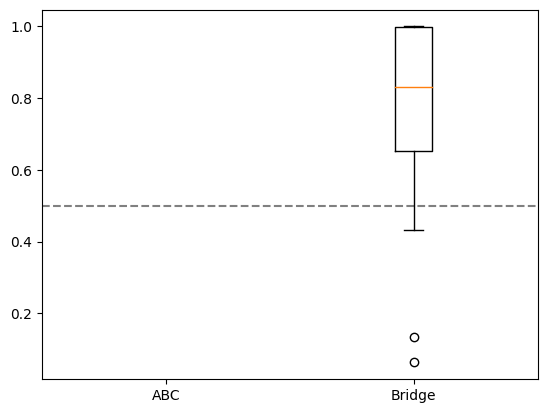

In [200]:
p_ABC = (ABC_norm2)/(1+np.array((ABC_norm2)))
p_Bridge = np.array(np.exp(Bridge_norm2))/(1+np.array(np.exp(Bridge_norm2)))
plt.axhline(0.5,color="grey",linestyle="--")
plt.boxplot([p_ABC,p_Bridge],labels=["ABC","Bridge"])

## For N = 100

In [213]:
BF_ABC_norm.argmax()

64

In [218]:
BF_ABC_norm[np.argmax(BF_ABC_norm)]

1000.0

BF :
ABC : min = 0.010101010101010102 max = 1000.0 mean = 36.99633524261127
Bridge : min = 0.0020641046614167076 max = 1000.0 mean = 60.59462170869243


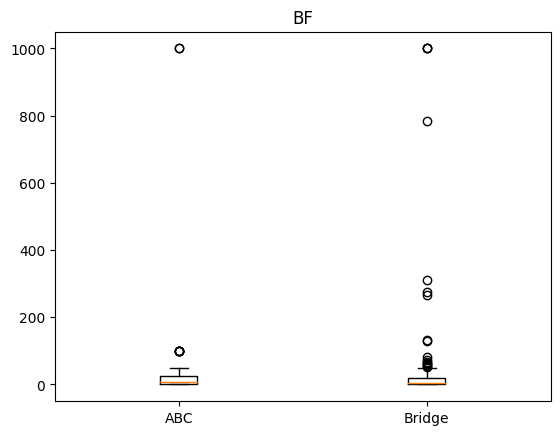

log BF
ABC : min = -4.59511985013459 max = 6.907755278982137 mean = 1.9049588899473868
Bridge : min = -6.1830587245977 max = 6.907755278982137 mean = 1.4502640487118423


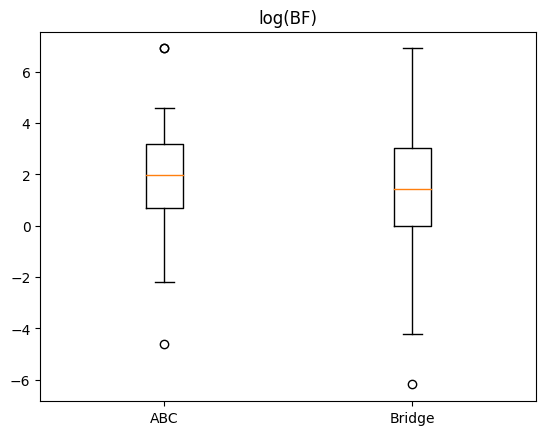

Probability of model 1
ABC : min = 0.01 max = 0.999000999000999 mean = 0.78548001998002
Bridge : min = 0.002059852909424532 max = 0.999000999000999 mean = 0.6881433193239753


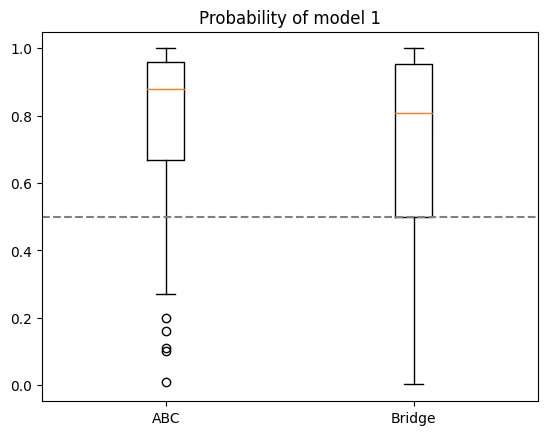

In [220]:
BF_ABC_norm = np.array(ABC_norm)
BF_Bridge_norm = np.array(np.exp(Bridge_norm))
BF_Bridge_norm[np.where(BF_Bridge_norm>1000)]=1000

print("BF :\nABC : min = {} max = {} mean = {}\nBridge : min = {} max = {} mean = {}".format(np.min(BF_ABC_norm),np.max(BF_ABC_norm),np.mean(BF_ABC_norm),np.min(BF_Bridge_norm),np.max(BF_Bridge_norm),np.mean(BF_Bridge_norm)))
plt.boxplot([BF_ABC_norm,BF_Bridge_norm],labels=["ABC","Bridge"]);
plt.title("BF")
plt.show()
plt.boxplot([np.log(BF_ABC_norm),np.log(BF_Bridge_norm)],labels=["ABC","Bridge"]);
plt.title("log(BF)")
print("log BF\nABC : min = {} max = {} mean = {}\nBridge : min = {} max = {} mean = {}".format(np.min(np.log(BF_ABC_norm)),np.max(np.log(BF_ABC_norm)),np.mean(np.log(BF_ABC_norm)),np.min(np.log(BF_Bridge_norm)),np.max(np.log(BF_Bridge_norm)),np.mean(np.log(BF_Bridge_norm))))
plt.show()
p_ABC_norm = BF_ABC_norm/(1+BF_ABC_norm)
p_Bridge_norm = BF_Bridge_norm/(1+BF_Bridge_norm)
plt.boxplot([p_ABC_norm,p_Bridge_norm],labels=["ABC","Bridge"]);
plt.title("Probability of model 1")
print("Probability of model 1\nABC : min = {} max = {} mean = {}\nBridge : min = {} max = {} mean = {}".format(np.min(p_ABC_norm),np.max(p_ABC_norm),np.mean(p_ABC_norm),np.min(p_Bridge_norm),np.max(p_Bridge_norm),np.mean(p_Bridge_norm)))
plt.axhline(0.5,color="grey",linestyle="--")


BF :
ABC : min = 3.761904761904762 max = inf mean = inf
Bridge : min = 0.06664332237475992 max = 366279.5298040942 mean = 22029.13635170613


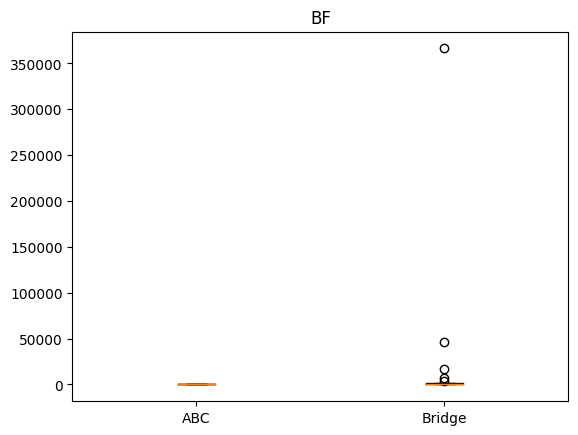

log BF
ABC : min = 1.3249254147435985 max = inf mean = inf
Bridge : min = -2.708400426802673 max = 12.811152063514648 mean = 3.512607703897823


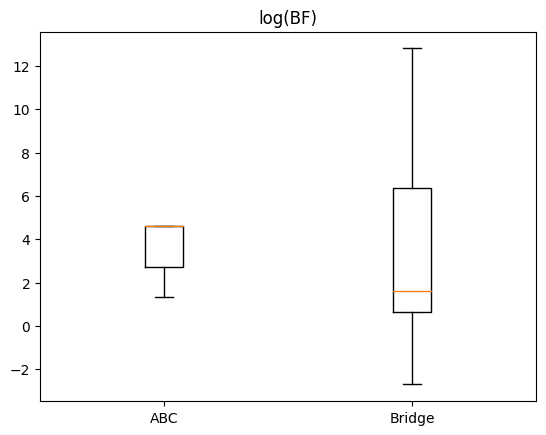

Probability of model 1
ABC : min = nan max = nan mean = nan
Bridge : min = 0.06247948210690163 max = 0.9999972698521525 mean = 0.7576397670810627


/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


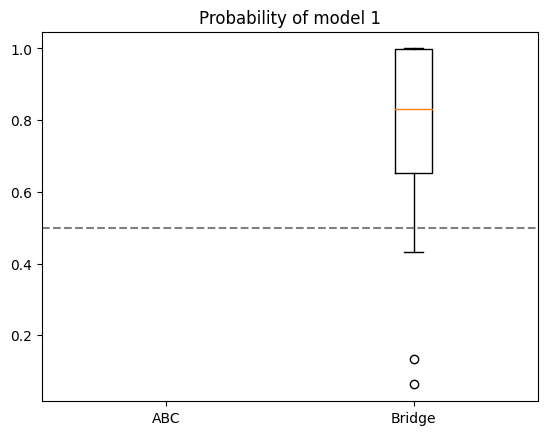

In [221]:
BF_ABC_norm = np.array(ABC_norm2)
BF_Bridge_norm = np.array(np.exp(Bridge_norm2))
#BF_Bridge_norm[np.where(BF_Bridge_norm>1000)]=1000

print("BF :\nABC : min = {} max = {} mean = {}\nBridge : min = {} max = {} mean = {}".format(np.min(BF_ABC_norm),np.max(BF_ABC_norm),np.mean(BF_ABC_norm),np.min(BF_Bridge_norm),np.max(BF_Bridge_norm),np.mean(BF_Bridge_norm)))
plt.boxplot([BF_ABC_norm,BF_Bridge_norm],labels=["ABC","Bridge"]);
plt.title("BF")
plt.show()
plt.boxplot([np.log(BF_ABC_norm),np.log(BF_Bridge_norm)],labels=["ABC","Bridge"]);
plt.title("log(BF)")
print("log BF\nABC : min = {} max = {} mean = {}\nBridge : min = {} max = {} mean = {}".format(np.min(np.log(BF_ABC_norm)),np.max(np.log(BF_ABC_norm)),np.mean(np.log(BF_ABC_norm)),np.min(np.log(BF_Bridge_norm)),np.max(np.log(BF_Bridge_norm)),np.mean(np.log(BF_Bridge_norm))))
plt.show()
p_ABC_norm = BF_ABC_norm/(1+BF_ABC_norm)
p_Bridge_norm = BF_Bridge_norm/(1+BF_Bridge_norm)
plt.boxplot([p_ABC_norm,p_Bridge_norm],labels=["ABC","Bridge"]);
plt.title("Probability of model 1")
print("Probability of model 1\nABC : min = {} max = {} mean = {}\nBridge : min = {} max = {} mean = {}".format(np.min(p_ABC_norm),np.max(p_ABC_norm),np.mean(p_ABC_norm),np.min(p_Bridge_norm),np.max(p_Bridge_norm),np.mean(p_Bridge_norm)))
plt.axhline(0.5,color="grey",linestyle="--")


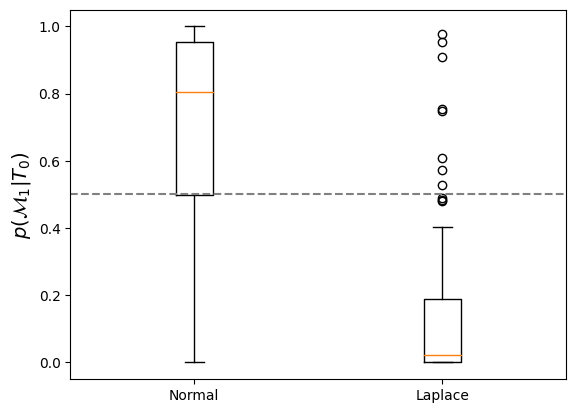

In [235]:
BF_norm = Bridge_norm
BF_laplace = Bridge_lp
P_norm = np.exp(BF_norm)/(1+np.exp(BF_norm))
P_laplace = np.exp(BF_laplace)/(1+np.exp(BF_laplace))
plt.boxplot([P_norm,P_laplace],labels=["Normal","Laplace"])
plt.ylabel("$p(\mathcal{M}_1|T_0)$",fontsize=14)
plt.axhline(0.5,color="grey",linestyle="--")

## For Slides

### Comparaison ABC/Bridge

1001

In [240]:
BF_ABC_lp, BF_ABC_norm = [],[]
BF_Bridge_lp, BF_Bridge_norm = [],[]
T = 10000
N = 1001
LBF_lp , LBF_norm = [],[]

for _ in tqdm(range(10)):
    X_lp = np.random.laplace(0,1/np.sqrt(2),N)
    med_lp,MAD_lp = np.median(X_lp),median_abs_deviation(X_lp)
    BF_ABC_lp.append(ABC_Model_Paper(T,N,med_lp,MAD_lp)["BF"])
    MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_lp,MAD_lp,List_X = True,verbose=False)
    MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_lp,MAD_lp,List_X = True,verbose=False)
    X_Normal,X_Laplace = np.array(MCMC_norm["X"][1:]),np.array(MCMC_laplace["X"][1:])
    mu_Normal, mu_Laplace= np.array(MCMC_norm["chains"]["loc"]),np.array(MCMC_laplace["chains"]["loc"])
    ratio_num = -np.array([log_ratio_normal_laplace(X_Laplace[i],mu_Laplace[i]) for i in range(len(X_Laplace))])
    ratio_den = np.array([log_ratio_normal_laplace(X_Normal[i],mu_Normal[i]) for i in range(len(X_Normal))])
    print("Bridge LP...",end="")
    logBF_bridge = logBF_Bridge_ratio(ratio_num,ratio_den,BF_init = 2, epsilon=0.01, a=0, n_iter = 100, verbose = False)
    BF_Bridge_lp.append(logBF_bridge[-1])
    LBF_lp.append(logBF_bridge)
    print("Done! Bridge = {} (en {} iterations) ABC = {}".format(BF_Bridge_lp[-1],len(logBF_bridge),np.log(BF_ABC_lp[-1])))
    
    X_norm = np.random.normal(0,1,N)
    med_norm,MAD_norm = np.median(X_norm),median_abs_deviation(X_norm)
    BF_ABC_norm.append(ABC_Model_Paper(T,N,med_norm,MAD_norm)["BF"])
    MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_norm,MAD_norm,List_X = True,verbose=False)
    MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_norm,MAD_norm,List_X = True,verbose=False)
    X_Normal,X_Laplace = np.array(MCMC_norm["X"][1:]),np.array(MCMC_laplace["X"][1:])
    mu_Normal, mu_Laplace= np.array(MCMC_norm["chains"]["loc"]),np.array(MCMC_laplace["chains"]["loc"])
    ratio_num = -np.array([log_ratio_normal_laplace(X_Laplace[i],mu_Laplace[i]) for i in range(len(X_Laplace))])
    ratio_den = np.array([log_ratio_normal_laplace(X_Normal[i],mu_Normal[i]) for i in range(len(X_Normal))])
    print("Bridge Norm...",end="")
    logBF_bridge = logBF_Bridge_ratio(ratio_num,ratio_den,BF_init = 2, epsilon=0.001, a=0, n_iter = 100, verbose = False)
    BF_Bridge_norm.append(logBF_bridge[-1])
    LBF_norm.append(logBF_bridge)
    print("Done! Bridge = {} (en {} iterations) ABC = {}".format(BF_Bridge_norm[-1],len(logBF_bridge),np.log(BF_ABC_norm[-1])))
    

  0%|          | 0/10 [00:00<?, ?it/s]

Model1: 0.00%, Model2: 100.00%
Bridge LP...Done! Bridge = -30.036626902166308 (en 101 iterations) ABC = -inf
Model1: 100.00%, Model2: 0.00%
Bridge Norm...

 10%|█         | 1/10 [01:22<12:22, 82.53s/it]

Done! Bridge = 2.000001508022315 (en 101 iterations) ABC = inf
Model1: 0.00%, Model2: 100.00%
Bridge LP...Done! Bridge = -15.156998657032554 (en 101 iterations) ABC = -inf
Model1: 100.00%, Model2: 0.00%
Bridge Norm...

 20%|██        | 2/10 [02:43<10:51, 81.47s/it]

Done! Bridge = 2.001220596913484 (en 101 iterations) ABC = inf
Model1: 0.00%, Model2: 100.00%
Bridge LP...Done! Bridge = -23.303244548568355 (en 101 iterations) ABC = -inf
Model1: 100.00%, Model2: 0.00%
Bridge Norm...

 30%|███       | 3/10 [04:04<09:28, 81.26s/it]

Done! Bridge = 3.798381872720782 (en 101 iterations) ABC = inf
Model1: 0.00%, Model2: 100.00%
Bridge LP...Done! Bridge = -2.206837154631617 (en 101 iterations) ABC = -inf
Model1: 100.00%, Model2: 0.00%
Bridge Norm...

 40%|████      | 4/10 [05:24<08:04, 80.83s/it]

Done! Bridge = 2.0 (en 101 iterations) ABC = inf
Model1: 0.00%, Model2: 100.00%
Bridge LP...Done! Bridge = -6.283487053366903 (en 101 iterations) ABC = -inf
Model1: 100.00%, Model2: 0.00%
Bridge Norm...

 50%|█████     | 5/10 [06:44<06:43, 80.61s/it]

Done! Bridge = 2.0000025276373563 (en 101 iterations) ABC = inf
Model1: 0.00%, Model2: 100.00%
Bridge LP...Done! Bridge = -31.51241793130848 (en 101 iterations) ABC = -inf
Model1: 100.00%, Model2: 0.00%
Bridge Norm...

 60%|██████    | 6/10 [08:08<05:26, 81.58s/it]

Done! Bridge = 2.000000002095746 (en 101 iterations) ABC = inf
Model1: 0.00%, Model2: 100.00%
Bridge LP...Done! Bridge = -21.93530830005288 (en 101 iterations) ABC = -inf
Model1: 100.00%, Model2: 0.00%
Bridge Norm...

 70%|███████   | 7/10 [09:28<04:03, 81.26s/it]

Done! Bridge = 2.0 (en 101 iterations) ABC = inf
Model1: 0.00%, Model2: 100.00%
Bridge LP...Done! Bridge = -4.490022607897766 (en 101 iterations) ABC = -inf
Model1: 100.00%, Model2: 0.00%
Bridge Norm...

 80%|████████  | 8/10 [10:52<02:44, 82.06s/it]

Done! Bridge = 2.000115468966314 (en 101 iterations) ABC = inf
Model1: 0.00%, Model2: 100.00%
Bridge LP...Done! Bridge = -7.320271269141004 (en 101 iterations) ABC = -inf
Model1: 100.00%, Model2: 0.00%
Bridge Norm...

 90%|█████████ | 9/10 [12:15<01:22, 82.46s/it]

Done! Bridge = 2.000000001391598 (en 101 iterations) ABC = inf
Model1: 0.00%, Model2: 100.00%
Bridge LP...Done! Bridge = -24.912564921699055 (en 101 iterations) ABC = -inf
Model1: 100.00%, Model2: 0.00%
Bridge Norm...

100%|██████████| 10/10 [13:40<00:00, 82.04s/it]

Done! Bridge = 2.0 (en 101 iterations) ABC = inf


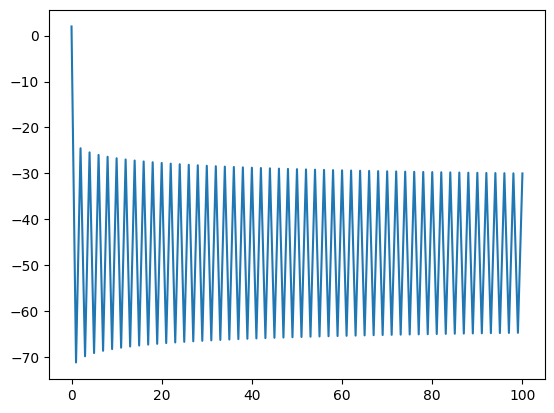

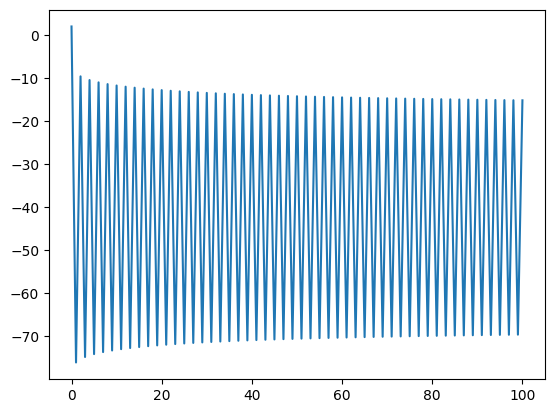

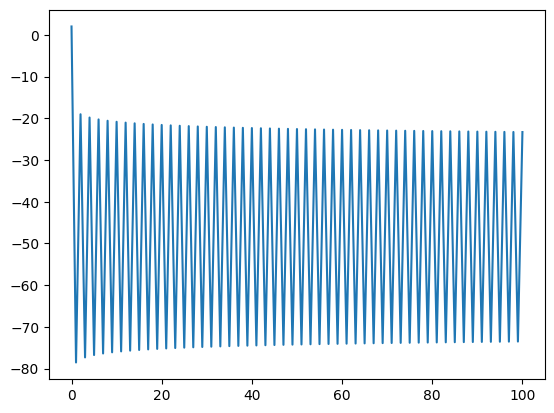

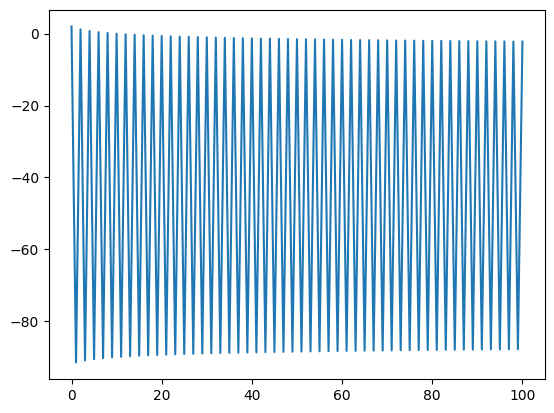

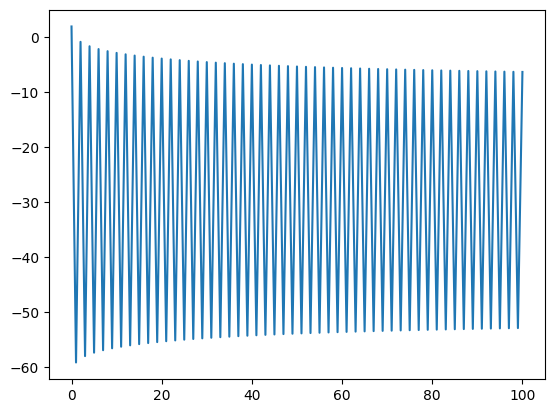

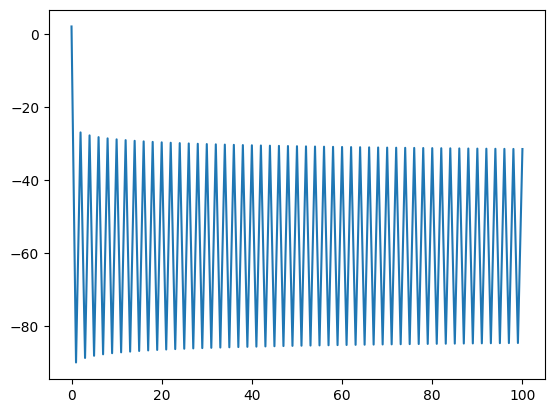

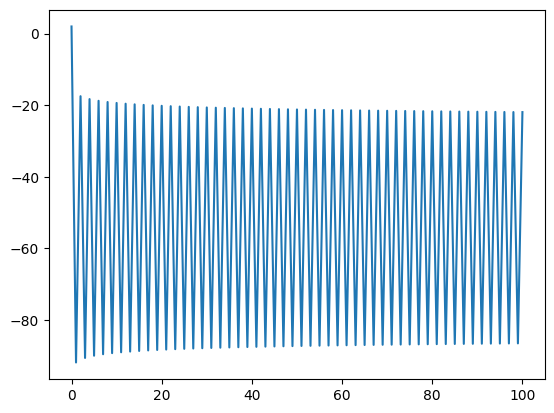

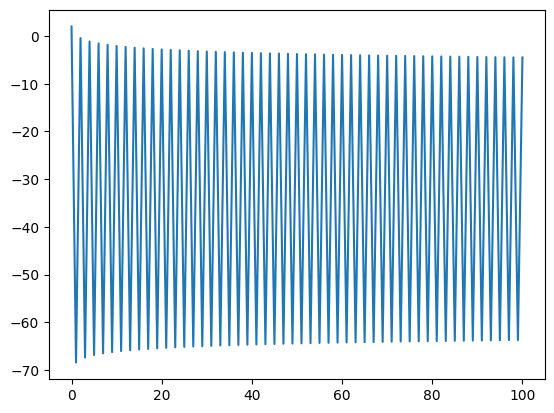

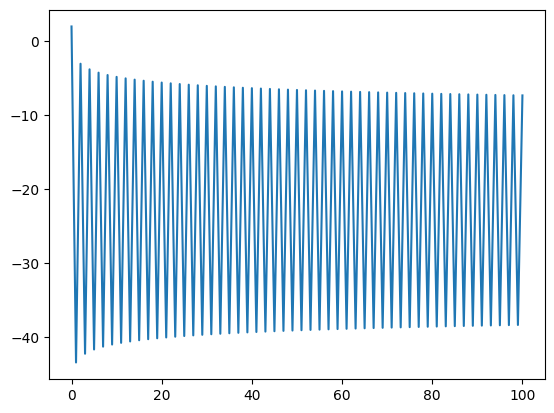

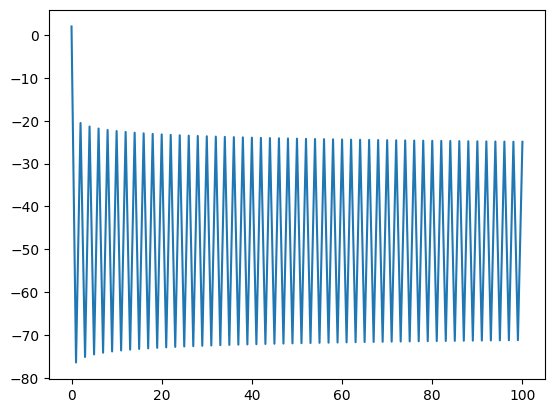

In [245]:
for l in LBF_lp:
    plt.plot(l)
    plt.show()

### Bridge Normal/Laplace

In [253]:
test = [[1,2,3],[4,5,6]]
test[0].append(9)
test

[[1, 2, 3, 9], [4, 5, 6]]

In [191]:
np.array(Norm_N).shape

NameError: name 'Norm_N' is not defined

In [256]:
# Norm_N, Laplace_N = [],[]
T=10000
for j,N in enumerate([11,101,501]):
    norm_n,lp_n = [],[]
    print("N = {}".format(N))
    for i in tqdm(range(30)):
        X_norm = np.random.normal(0,1,N)
        med_norm,MAD_norm = np.median(X_norm),median_abs_deviation(X_norm)
        MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_norm,MAD_norm,List_X = True,verbose=False)
        MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_norm,MAD_norm,List_X = True,verbose=False)
        X_Normal,X_Laplace = np.array(MCMC_norm["X"][1:]),np.array(MCMC_laplace["X"][1:])
        mu_Normal, mu_Laplace= np.array(MCMC_norm["chains"]["loc"]),np.array(MCMC_laplace["chains"]["loc"])
        ratio_num = -np.array([log_ratio_normal_laplace(X_Laplace[i],mu_Laplace[i]) for i in range(len(X_Laplace))])
        ratio_den = np.array([log_ratio_normal_laplace(X_Normal[i],mu_Normal[i]) for i in range(len(X_Normal))])
        logBF_bridge = logBF_Bridge_ratio(ratio_num,ratio_den,BF_init = 2, epsilon=0.001, a=0, n_iter = 1000, verbose = False)
        Norm_N[j].append(logBF_bridge[-1])
        print("Norm: med = {} MAD = {}".format(med_norm,MAD_norm))
        print("LogBF = {}".format(logBF_bridge[-1]))
        
        X_lp = np.random.laplace(0,1/np.sqrt(2),N)
        med_lp,MAD_lp = np.median(X_lp),median_abs_deviation(X_lp)
        MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_lp,MAD_lp,List_X = True,verbose=False)
        MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_lp,MAD_lp,List_X = True,verbose=False)
        X_Normal,X_Laplace = np.array(MCMC_norm["X"][1:]),np.array(MCMC_laplace["X"][1:])
        mu_Normal, mu_Laplace= np.array(MCMC_norm["chains"]["loc"]),np.array(MCMC_laplace["chains"]["loc"])
        ratio_num = -np.array([log_ratio_normal_laplace(X_Laplace[i],mu_Laplace[i]) for i in range(len(X_Laplace))])
        ratio_den = np.array([log_ratio_normal_laplace(X_Normal[i],mu_Normal[i]) for i in range(len(X_Normal))])
        logBF_bridge = logBF_Bridge_ratio(ratio_num,ratio_den,BF_init = 2, epsilon=0.001, a=0, n_iter = 1000, verbose = False)
        Laplace_N[j].append(logBF_bridge[-1])
        print("Laplace: med = {} MAD = {}".format(med_lp,MAD_lp))
        print("LogBF = {}".format(logBF_bridge[-1]))
        



N = 11


  0%|          | 0/30 [00:00<?, ?it/s]

Norm: med = -0.13634488333304232 MAD = 0.9509811518681842
LogBF = 0.7940498361790223


  3%|▎         | 1/30 [00:46<22:41, 46.95s/it]

Laplace: med = -0.12111715261858134 MAD = 0.3556299769086054
LogBF = -0.6562949160541258
Norm: med = -0.33836646288724226 MAD = 0.8415721831278626
LogBF = 0.6163862244572487


  7%|▋         | 2/30 [01:33<21:42, 46.51s/it]

Laplace: med = -0.12356569250683597 MAD = 0.40087462463962764
LogBF = -1.0925910220118515
Norm: med = -0.6018763395838024 MAD = 0.5889491253827027
LogBF = 0.07879914185532133


 10%|█         | 3/30 [02:21<21:19, 47.40s/it]

Laplace: med = 0.36759984965988435 MAD = 1.2096178957045531
LogBF = 0.3298341449607607
Norm: med = 0.38026312907156723 MAD = 0.4595761816702195
LogBF = -0.061231831770943934


 13%|█▎        | 4/30 [03:08<20:23, 47.06s/it]

Laplace: med = 0.1479825645725155 MAD = 0.3777753124256978
LogBF = -0.6939416053488561
Norm: med = 0.08764723091248944 MAD = 0.6711979248165185
LogBF = 0.4086530444017846


 17%|█▋        | 5/30 [03:54<19:28, 46.73s/it]

Laplace: med = 0.23743043479473674 MAD = 0.48125382363688535
LogBF = -0.7244175210829171
Norm: med = -0.2193722766367454 MAD = 0.43778349963953267
LogBF = -0.8837937931940738


 20%|██        | 6/30 [04:40<18:36, 46.53s/it]

Laplace: med = 0.3879222010317397 MAD = 0.27139060029503315
LogBF = -0.8244857620155699
Norm: med = 0.33207154264450434 MAD = 1.0328096255926482
LogBF = 1.1729652592566469


 23%|██▎       | 7/30 [05:26<17:47, 46.42s/it]

Laplace: med = -0.06059410304999514 MAD = 0.37181151230822995
LogBF = -0.04764360298667025
Norm: med = 0.6482584939960546 MAD = 0.6559110984839468
LogBF = 0.11938377567699998


 27%|██▋       | 8/30 [06:13<17:02, 46.46s/it]

Laplace: med = 0.3131627016434654 MAD = 0.3703303766373204
LogBF = -0.7607657062220392
Norm: med = 0.3662935764706799 MAD = 0.15817381661122526
LogBF = -2.0216652387139016


 30%|███       | 9/30 [07:01<16:25, 46.93s/it]

Laplace: med = 0.014249104677685028 MAD = 1.0241321558998289
LogBF = 1.4214558209684052
Norm: med = -0.08530866654919618 MAD = 0.19477422425691698
LogBF = -1.4745200279695228


 33%|███▎      | 10/30 [07:51<16:00, 48.00s/it]

Laplace: med = -0.08724973453594817 MAD = 0.34653080289547167
LogBF = -2.0685960265736947
Norm: med = -0.4085057375773136 MAD = 0.6432283314417375
LogBF = -1.5235264370444126


 37%|███▋      | 11/30 [08:40<15:17, 48.31s/it]

Laplace: med = -0.3987260895576056 MAD = 0.46979374278204367
LogBF = -0.3703276038988559
Norm: med = -0.6767966832492055 MAD = 0.860880873182993
LogBF = 1.0909708775919693


 40%|████      | 12/30 [09:28<14:26, 48.13s/it]

Laplace: med = 0.03507546696239415 MAD = 0.3292158343700273
LogBF = -1.4048101065872487
Norm: med = 0.06556337316638279 MAD = 0.4919533815813647
LogBF = -0.32948453588557935


 43%|████▎     | 13/30 [10:15<13:34, 47.94s/it]

Laplace: med = 0.2700577401195967 MAD = 0.6690306182748618
LogBF = 0.11169131456823234
Norm: med = -0.6413431716142431 MAD = 0.9034914149086156
LogBF = 1.663531974063904


 47%|████▋     | 14/30 [11:02<12:42, 47.63s/it]

Laplace: med = -0.022541521458068866 MAD = 0.14999708703156392
LogBF = -1.508153040242167
Norm: med = 0.4726881099256124 MAD = 0.6346480131840445
LogBF = 0.5767701735249249


 50%|█████     | 15/30 [11:51<12:01, 48.09s/it]

Laplace: med = -0.06107131356319627 MAD = 0.6780308465432996
LogBF = 0.29725478196725685
Norm: med = 0.14284297518260256 MAD = 0.8380875186579401
LogBF = 1.0896879626661695


 53%|█████▎    | 16/30 [12:44<11:32, 49.44s/it]

Laplace: med = 0.23302561344585998 MAD = 0.5575459310559909
LogBF = 0.5864310099278889
Norm: med = -0.1829475791889266 MAD = 0.457300034049438
LogBF = -0.0005249555649342597


 57%|█████▋    | 17/30 [13:35<10:49, 49.96s/it]

Laplace: med = 0.0996863061783893 MAD = 0.31751950726372286
LogBF = -0.32707565781187586
Norm: med = -0.0150285779667228 MAD = 0.6722050539640112
LogBF = -0.12415627783663918


 60%|██████    | 18/30 [14:27<10:07, 50.64s/it]

Laplace: med = -0.1914132360004916 MAD = 0.5256646835771679
LogBF = 0.1581156997612787
Norm: med = -0.1416153161285226 MAD = 0.6458590689800561
LogBF = 0.4967293240834598


 63%|██████▎   | 19/30 [15:19<09:19, 50.87s/it]

Laplace: med = -0.040852846430914753 MAD = 0.7060549584819931
LogBF = 0.23705616869099178
Norm: med = -0.6759100399777529 MAD = 0.38907850737962746
LogBF = -0.6075862503884899


 67%|██████▋   | 20/30 [16:11<08:34, 51.44s/it]

Laplace: med = 0.150459566993529 MAD = 0.2814666122493378
LogBF = -0.7046274829847947
Norm: med = 0.34047630207596263 MAD = 0.6251256136255223
LogBF = 0.748600336306553


 70%|███████   | 21/30 [17:02<07:41, 51.24s/it]

Laplace: med = 0.03178630137982177 MAD = 0.4413126445487407
LogBF = -0.3705086665852555
Norm: med = -0.7397680214828669 MAD = 0.7031463584751075
LogBF = 0.18050983353742378


 73%|███████▎  | 22/30 [17:55<06:54, 51.81s/it]

Laplace: med = -0.24372007352822675 MAD = 0.6322529951424175
LogBF = 0.39635708705392325
Norm: med = 0.24163624566498168 MAD = 0.6455925345512885
LogBF = 0.6000881357393029


 77%|███████▋  | 23/30 [18:46<05:59, 51.38s/it]

Laplace: med = 0.19056777207453213 MAD = 0.31839911343266714
LogBF = -0.8769512587377681
Norm: med = 0.12477924667029404 MAD = 0.4116929882481972
LogBF = -0.21805102947913202


 80%|████████  | 24/30 [19:36<05:05, 50.90s/it]

Laplace: med = 0.0680312271984985 MAD = 0.6596972229140314
LogBF = -0.08374719773545003
Norm: med = 0.2368487258044711 MAD = 0.49462772240098096
LogBF = -0.2178477224802462


 83%|████████▎ | 25/30 [20:28<04:16, 51.34s/it]

Laplace: med = -0.08565276068061987 MAD = 0.36814038663873416
LogBF = -0.8753667455002434
Norm: med = 0.3758599778114631 MAD = 0.6127915368191766
LogBF = 0.030447434697736142


 87%|████████▋ | 26/30 [21:18<03:24, 51.04s/it]

Laplace: med = 0.41224504902110215 MAD = 0.7407453058434226
LogBF = 0.5315378677753335
Norm: med = -0.15247446182376842 MAD = 0.7992732314374009
LogBF = 0.8246867404196356


 90%|█████████ | 27/30 [22:12<02:35, 51.73s/it]

Laplace: med = 0.21255697821083774 MAD = 0.2005446495547871
LogBF = -0.6734462849364133
Norm: med = 0.27079508049485507 MAD = 0.3163247267779619
LogBF = -0.7901866683333161


 93%|█████████▎| 28/30 [23:02<01:42, 51.22s/it]

Laplace: med = -0.3070079143035273 MAD = 0.2698144026841666
LogBF = -0.830487972216261
Norm: med = 0.02143616258525886 MAD = 0.36854181188166835
LogBF = -1.727859350846776


 97%|█████████▋| 29/30 [23:53<00:51, 51.33s/it]

Laplace: med = 0.18751980666893742 MAD = 0.15362741550912185
LogBF = -1.318337397362054
Norm: med = -0.06251400083687375 MAD = 0.4372352287574985
LogBF = -0.260883920838312


100%|██████████| 30/30 [24:43<00:00, 49.46s/it]


Laplace: med = -0.11762392264972328 MAD = 0.3737416873168035
LogBF = -0.6108783116254344
N = 101


  0%|          | 0/30 [00:00<?, ?it/s]

Norm: med = 0.03172697007797557 MAD = 0.5152228815055591
LogBF = 0.7146608444933644


  3%|▎         | 1/30 [01:20<38:52, 80.43s/it]

Laplace: med = 0.002424420657120189 MAD = 0.7234204011278653
LogBF = 4.639094829005942
Norm: med = 0.06273950661632637 MAD = 0.6183430051803038
LogBF = -2.0071121082181618


  7%|▋         | 2/30 [02:25<33:26, 71.67s/it]

Laplace: med = 0.07956676794495172 MAD = 0.39720719507912994
LogBF = -10.048518232118337
Norm: med = -0.06623587297518432 MAD = 0.6766919345808293
LogBF = 2.5327930160208187


 10%|█         | 3/30 [04:15<40:04, 89.06s/it]

Laplace: med = 0.0825076512940401 MAD = 0.4532235103165439
LogBF = -8.475202531540207
Norm: med = -0.08633926928761511 MAD = 0.6210060229370258
LogBF = 4.253994081891917


 13%|█▎        | 4/30 [05:43<38:19, 88.45s/it]

Laplace: med = -0.04165124615124591 MAD = 0.458986447824703
LogBF = -7.6463839574915005
Norm: med = 0.024369318530110703 MAD = 0.5386375385277727
LogBF = -2.589568064442564


 17%|█▋        | 5/30 [09:24<56:52, 136.51s/it]

Laplace: med = -0.060081791576602914 MAD = 0.39539365783893243
LogBF = -10.813736510375062
Norm: med = -0.04041880479935653 MAD = 0.859540376414153
LogBF = 5.482957299342722


 20%|██        | 6/30 [14:31<1:17:46, 194.46s/it]

Laplace: med = -0.032186809391815445 MAD = 0.4560718798345339
LogBF = -9.162444225060128
Norm: med = -0.13773438491718976 MAD = 0.6273207522226603
LogBF = -1.5666912326590339


 23%|██▎       | 7/30 [18:27<1:19:41, 207.89s/it]

Laplace: med = -0.08553844708497342 MAD = 0.4500302058440265
LogBF = -6.471688422010651
Norm: med = -0.12560255328155262 MAD = 0.6779544341431372
LogBF = 6.131626147813145


 27%|██▋       | 8/30 [19:24<58:38, 159.95s/it]  

Laplace: med = -0.04649303705333681 MAD = 0.5428983451147904
LogBF = -0.5521386076778967
Norm: med = -0.1403606545189857 MAD = 0.6990544577447069
LogBF = 2.5823904773896844


 30%|███       | 9/30 [20:57<48:36, 138.87s/it]

Laplace: med = 0.002130365616241936 MAD = 0.4757226997201546
LogBF = -3.4465517663910825
Norm: med = 0.004642064188443869 MAD = 0.7303136860343097
LogBF = 3.7198239284188093


 33%|███▎      | 10/30 [22:01<38:38, 115.91s/it]

Laplace: med = -0.023817413753992572 MAD = 0.439971897470411
LogBF = -6.3232881398110745
Norm: med = 0.022591732827035183 MAD = 0.629654219394084
LogBF = 1.9558042051812774


 37%|███▋      | 11/30 [24:06<37:32, 118.56s/it]

Laplace: med = -0.11951610932327356 MAD = 0.36348876200523716
LogBF = -10.213478757572492
Norm: med = 0.0921730481483646 MAD = 0.5814489632625806
LogBF = -1.4967928909300277


 40%|████      | 12/30 [25:01<29:49, 99.40s/it] 

Laplace: med = -0.09122316992178342 MAD = 0.4390609735223285
LogBF = -5.824786810599953
Norm: med = -0.04433258366145506 MAD = 0.5887955672995149
LogBF = -0.9463311543562996


 43%|████▎     | 13/30 [29:30<42:43, 150.80s/it]

Laplace: med = -0.06534116456011543 MAD = 0.5478105826041848
LogBF = -4.707883317860821
Norm: med = 0.11128850072596086 MAD = 0.608802158823896
LogBF = 0.6032813242929436


 47%|████▋     | 14/30 [31:25<37:16, 139.77s/it]

Laplace: med = 0.09647908952695299 MAD = 0.6056760227615781
LogBF = 0.6325505063269565
Norm: med = 0.3141118733927452 MAD = 0.6047696746164989
LogBF = -1.7728074040397184


 50%|█████     | 15/30 [33:26<33:31, 134.12s/it]

Laplace: med = -0.08428381757025494 MAD = 0.42548254362305227
LogBF = -3.482855531386499
Norm: med = -0.05596709674895926 MAD = 0.8091829104506406
LogBF = 6.477773549154469


 53%|█████▎    | 16/30 [36:32<34:59, 149.94s/it]

Laplace: med = 0.033448520371042394 MAD = 0.4972895069886625
LogBF = -3.3279851770792606
Norm: med = 0.12091490511988434 MAD = 0.713655017025959
LogBF = -0.9258556844310215


 57%|█████▋    | 17/30 [40:10<36:53, 170.28s/it]

Laplace: med = -0.045625186653569565 MAD = 0.3951996904513289
LogBF = -14.373697308633865
Norm: med = -0.11584016576490165 MAD = 0.6979082311554231
LogBF = 5.123750658586273


 60%|██████    | 18/30 [41:07<27:15, 136.30s/it]

Laplace: med = -0.07017963506640539 MAD = 0.4410438639795032
LogBF = -3.672703250824311
Norm: med = -0.09121353831470629 MAD = 0.6566003087863236
LogBF = 3.218324579197599


 63%|██████▎   | 19/30 [42:14<21:09, 115.39s/it]

Laplace: med = 0.09155795859702222 MAD = 0.3789839164451427
LogBF = -6.39623111943564
Norm: med = -0.005550633864879568 MAD = 0.5227894277691393
LogBF = -1.3830489846011496


 67%|██████▋   | 20/30 [43:12<16:21, 98.18s/it] 

Laplace: med = -0.024245365035410374 MAD = 0.5655863119100948
LogBF = 1.325662684811764
Norm: med = -0.08961280333591935 MAD = 0.5826333750883061
LogBF = -2.3700753299780013


 70%|███████   | 21/30 [45:40<16:58, 113.14s/it]

Laplace: med = 0.10120625752544188 MAD = 0.44414614815447334
LogBF = -5.496133463903268
Norm: med = -0.030030044273460742 MAD = 0.5977491235203577
LogBF = -2.359474171644857


 73%|███████▎  | 22/30 [49:50<20:34, 154.36s/it]

Laplace: med = -0.03849157185263986 MAD = 0.38543603021538475
LogBF = -11.208623128586702
Norm: med = -0.005976924187546981 MAD = 0.695570847983612
LogBF = 1.4006959260498322


 77%|███████▋  | 23/30 [53:39<20:35, 176.53s/it]

Laplace: med = -0.02381373044922172 MAD = 0.3948742457051
LogBF = -12.905519536153847
Norm: med = -0.124366402668332 MAD = 0.7641020161263357
LogBF = 3.7250076730019703


 80%|████████  | 24/30 [56:07<16:47, 167.95s/it]

Laplace: med = -0.1572298176298563 MAD = 0.41720289049451287
LogBF = -7.20904895404555
Norm: med = -0.10175964772031314 MAD = 0.6453472075279246
LogBF = 0.4716069456840448


 83%|████████▎ | 25/30 [59:13<14:27, 173.54s/it]

Laplace: med = 0.08826920308478117 MAD = 0.493957346639455
LogBF = -2.2440725865525666
Norm: med = 0.19260452310176274 MAD = 0.7495747434167594
LogBF = 1.3727625984180687


 87%|████████▋ | 26/30 [1:02:09<11:36, 174.16s/it]

Laplace: med = -0.04331595451781969 MAD = 0.4270162393237502
LogBF = -9.427296358137452
Norm: med = -0.04352136994125068 MAD = 0.5571176815577242
LogBF = 0.4878788361416806


 90%|█████████ | 27/30 [1:03:26<07:15, 145.17s/it]

Laplace: med = -0.0981358346688666 MAD = 0.5435281520384245
LogBF = -2.8609698759216213
Norm: med = 0.0769985493880553 MAD = 0.5752596509128078
LogBF = -0.8020403789239277


 93%|█████████▎| 28/30 [1:04:45<04:10, 125.25s/it]

Laplace: med = 0.06541598601320334 MAD = 0.49417228768101773
LogBF = -2.676903177554548
Norm: med = 0.07847561178886 MAD = 0.7348283265443906
LogBF = 4.848615752321161


 97%|█████████▋| 29/30 [1:05:56<01:48, 108.95s/it]

Laplace: med = -0.014091996013248564 MAD = 0.5521148964317719
LogBF = -2.349807689088765
Norm: med = -0.06812159922371946 MAD = 0.6699349722905099
LogBF = 4.293504412412112


100%|██████████| 30/30 [1:07:02<00:00, 134.08s/it]


Laplace: med = -0.06513702963619532 MAD = 0.4479805415052091
LogBF = -7.876720814769665
N = 501


  0%|          | 0/30 [00:00<?, ?it/s]

Norm: med = -0.012790353264984854 MAD = 0.6399685393075127
LogBF = 2.000053170574226


  3%|▎         | 1/30 [06:42<3:14:25, 402.28s/it]

Laplace: med = 0.0063535308153465095 MAD = 0.5100148726508306
LogBF = -7.535046703050177
Norm: med = -0.06009779059391956 MAD = 0.675841697241674
LogBF = 2.00000124381927


  7%|▋         | 2/30 [13:25<3:07:56, 402.73s/it]

Laplace: med = 0.03216226994186344 MAD = 0.548556153012755
LogBF = -3.452716905384957
Norm: med = 0.008970145349597294 MAD = 0.7289669557044111
LogBF = 2.0000041350805624


 10%|█         | 3/30 [20:09<3:01:34, 403.50s/it]

Laplace: med = -0.01795024921648839 MAD = 0.47986565322956704
LogBF = -19.672867612314292
Norm: med = -0.09902057558686546 MAD = 0.6293375710280754
LogBF = 1.9999912159122228


 13%|█▎        | 4/30 [26:55<2:55:18, 404.58s/it]

Laplace: med = -0.009823939942509182 MAD = 0.4833316505729008
LogBF = -9.858137241832178
Norm: med = 0.007325871510251222 MAD = 0.7060237667619976
LogBF = 2.7310006139999494


 17%|█▋        | 5/30 [33:44<2:49:08, 405.92s/it]

Laplace: med = 0.01998933631135849 MAD = 0.4876264615641217
LogBF = -12.066248482496349
Norm: med = 0.006261126309061938 MAD = 0.6729173867601331
LogBF = 1.9999979829048904


 20%|██        | 6/30 [40:51<2:45:19, 413.30s/it]

Laplace: med = 0.041448587579960755 MAD = 0.4595359328011711
LogBF = -16.939651245428845
Norm: med = 0.09062683903029438 MAD = 0.6473713517794853
LogBF = 2.000300816236086


 23%|██▎       | 7/30 [47:50<2:39:09, 415.20s/it]

Laplace: med = -0.015710540788745116 MAD = 0.4754792934692946
LogBF = -22.2794525802478
Norm: med = 0.09319850491186012 MAD = 0.6561276323370422
LogBF = 2.000000028961722


 27%|██▋       | 8/30 [54:49<2:32:40, 416.37s/it]

Laplace: med = -0.02627435620730265 MAD = 0.530180142405342
LogBF = -3.3909255648346237
Norm: med = 0.05832599043797981 MAD = 0.6984892172556033
LogBF = 2.000000147649004


 30%|███       | 9/30 [1:01:49<2:26:03, 417.30s/it]

Laplace: med = -0.015705128809071843 MAD = 0.5068899235862259
LogBF = -6.658355901429886
Norm: med = 0.043059109347841414 MAD = 0.692205402617677
LogBF = 1.9999999440607485


 33%|███▎      | 10/30 [1:08:48<2:19:17, 417.89s/it]

Laplace: med = 0.008649191871503873 MAD = 0.43190298694643486
LogBF = -23.94604520557795
Norm: med = -0.031832560754428786 MAD = 0.5896820431451899
LogBF = 4.510058211502917


 37%|███▋      | 11/30 [1:12:53<1:55:34, 364.95s/it]

Laplace: med = -0.0386474700171784 MAD = 0.4898568987649622
LogBF = -13.560409375572243
Norm: med = 0.05112027752318966 MAD = 0.6825038374990121
LogBF = 2.10680178488737


 40%|████      | 12/30 [1:17:20<1:40:32, 335.15s/it]

Laplace: med = 0.037114622010684085 MAD = 0.47035163375049427
LogBF = -11.131029520827562
Norm: med = -0.07396352985023777 MAD = 0.6806740061594966
LogBF = 2.0036243758695917


 43%|████▎     | 13/30 [1:24:18<1:42:05, 360.32s/it]

Laplace: med = -0.042244697950739755 MAD = 0.46423268679821633
LogBF = -16.401695142806027
Norm: med = 0.021112195573265883 MAD = 0.7124783195805565
LogBF = 2.19810898928295


 47%|████▋     | 14/30 [1:31:20<1:41:01, 378.85s/it]

Laplace: med = -0.030778663765621987 MAD = 0.4990722073337258
LogBF = -10.01807171893649
Norm: med = 0.02373408531754665 MAD = 0.7377166402333513
LogBF = 11.86439166484918


 50%|█████     | 15/30 [1:38:26<1:38:17, 393.18s/it]

Laplace: med = -0.0302359798213329 MAD = 0.5700508371319976
LogBF = 1.9293901416596908
Norm: med = 0.08797560510312084 MAD = 0.7144904936615343
LogBF = 2.0000000270432565


 53%|█████▎    | 16/30 [1:45:25<1:33:32, 400.88s/it]

Laplace: med = 0.02313116901102186 MAD = 0.5120213955551309
LogBF = -6.213523206639014
Norm: med = -0.015453072524398554 MAD = 0.6755144101421917
LogBF = 10.515796102546922


 57%|█████▋    | 17/30 [1:52:22<1:27:53, 405.62s/it]

Laplace: med = 0.0018141792170469314 MAD = 0.4904705022034249
LogBF = -9.005297411868899
Norm: med = 0.030795071299245795 MAD = 0.6503939233256434
LogBF = 1.9998085559455756


 60%|██████    | 18/30 [1:59:20<1:21:54, 409.52s/it]

Laplace: med = 0.026631240013222663 MAD = 0.5376191498598168
LogBF = -3.858062143560887
Norm: med = -0.0005697048457846257 MAD = 0.6645832970081617
LogBF = 13.40225495884348


 63%|██████▎   | 19/30 [2:06:19<1:15:35, 412.34s/it]

Laplace: med = -0.044685014260493615 MAD = 0.5233586876529945
LogBF = -6.926906468884974
Norm: med = 0.002637991446346085 MAD = 0.6894559232746098
LogBF = 2.000000004764189


 67%|██████▋   | 20/30 [2:13:19<1:09:05, 414.54s/it]

Laplace: med = -0.0417569874506482 MAD = 0.5148232551883565
LogBF = -15.765382293410818
Norm: med = -0.04525969529725937 MAD = 0.6504230984732601
LogBF = 2.0864931092966614


 70%|███████   | 21/30 [2:20:20<1:02:27, 416.44s/it]

Laplace: med = 0.0062563548944821945 MAD = 0.5512298833372211
LogBF = -1.6391029098607115
Norm: med = -0.00555300216708421 MAD = 0.6842337265830194
LogBF = 1.9999999999111822


 73%|███████▎  | 22/30 [2:27:22<55:45, 418.16s/it]  

Laplace: med = -0.08288785892210794 MAD = 0.5098661426792996
LogBF = -9.272599979522502
Norm: med = -0.03604381369645079 MAD = 0.6353860806262389
LogBF = 2.5401816535391326


 77%|███████▋  | 23/30 [2:34:22<48:52, 418.93s/it]

Laplace: med = 0.0034992972338480873 MAD = 0.4546719014997622
LogBF = -17.220739134191252
Norm: med = -0.046216932191718164 MAD = 0.6771989083197257
LogBF = 2.947275671753733


 80%|████████  | 24/30 [3:12:29<1:37:55, 979.17s/it]

Laplace: med = -0.024847741444252534 MAD = 0.48796581062331973
LogBF = -10.847046017639247
Norm: med = -0.03573989800486148 MAD = 0.660814213391401
LogBF = 2.0000010841955156


 83%|████████▎ | 25/30 [3:45:41<1:46:55, 1283.09s/it]

Laplace: med = 0.025118889741598788 MAD = 0.5113795336100015
LogBF = -9.529514232422873


 83%|████████▎ | 25/30 [3:48:02<45:36, 547.31s/it]   


KeyboardInterrupt: 

In [261]:
med_norm,MAD_norm = np.median(X_norm),median_abs_deviation(X_norm)
MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_norm,MAD_norm,List_X = True,verbose=False)
MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_norm,MAD_norm,List_X = True,verbose=False)
X_Normal,X_Laplace = np.array(MCMC_norm["X"][1:]),np.array(MCMC_laplace["X"][1:])
mu_Normal, mu_Laplace= np.array(MCMC_norm["chains"]["loc"]),np.array(MCMC_laplace["chains"]["loc"])
ratio_num = -np.array([log_ratio_normal_laplace(X_Laplace[i],mu_Laplace[i]) for i in range(len(X_Laplace))])
ratio_den = np.array([log_ratio_normal_laplace(X_Normal[i],mu_Normal[i]) for i in range(len(X_Normal))])

In [262]:
logBF = logBF_Bridge_ratio(ratio_num,ratio_den,BF_init = 2, epsilon=0.001, a=0, n_iter = 19, verbose = True)

Iteration 1: log(numerator) = -16.529376383712947, log(denominator) = -15.869499736700778, logBF = -0.6598766470121689


Iteration 2: log(numerator) = -13.869499740144903, log(denominator) = -15.869499736470376, logBF = 1.9999999963254727


Iteration 3: log(numerator) = -16.529376380038418, log(denominator) = -15.869499736700778, logBF = -0.6598766433376397


Iteration 4: log(numerator) = -13.869499743819432, log(denominator) = -15.869499736470376, logBF = 1.9999999926509435


Iteration 5: log(numerator) = -16.52937637636389, log(denominator) = -15.869499736700778, logBF = -0.6598766396631106


Iteration 6: log(numerator) = -13.869499747493961, log(denominator) = -15.869499736470376, logBF = 1.9999999889764144


Iteration 7: log(numerator) = -16.52937637268936, log(denominator) = -15.869499736700778, logBF = -0.6598766359885815


Iteration 8: log(numerator) = -13.86949975116849, log(denominator) = -15.869499736470376, logBF = 1.9999999853018853


Iteration 9: log(numerator) = -16.52937

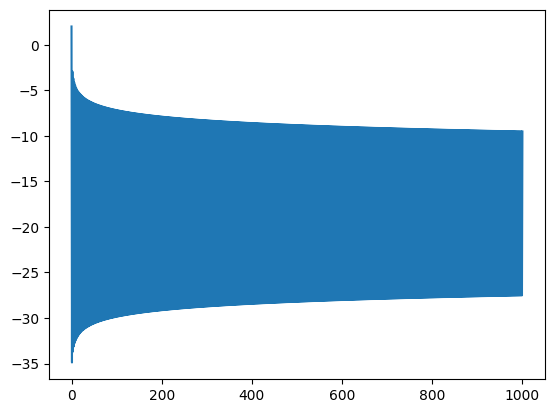

In [260]:
plt.plot(logBF_bridge)

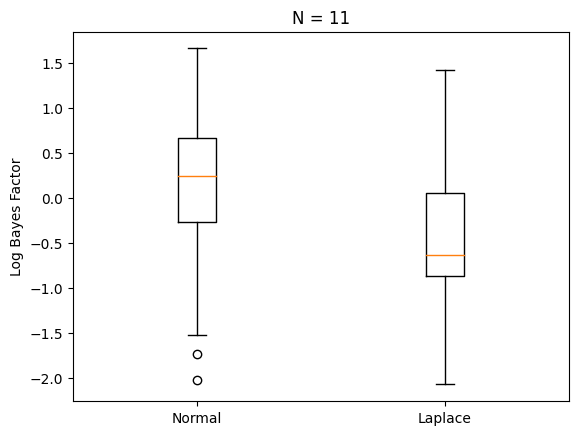

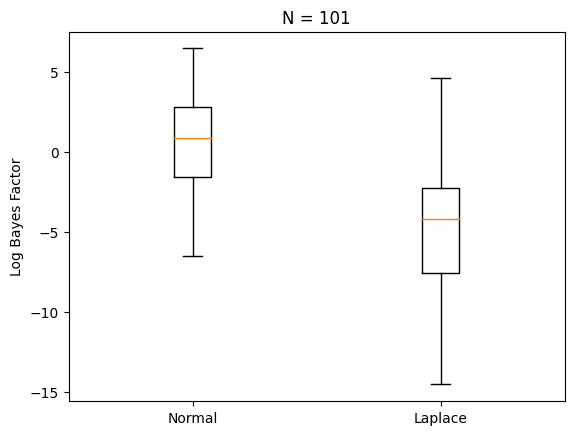

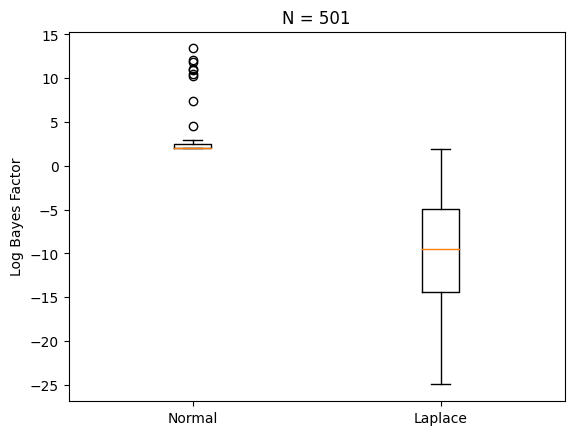

In [258]:
for i,n in enumerate([11,101,501]):
    plt.boxplot([Norm_N[i],Laplace_N[i]],labels=["Normal","Laplace"])
    plt.title("N = {}".format(n))
    plt.ylabel("Log Bayes Factor")
    plt.show()

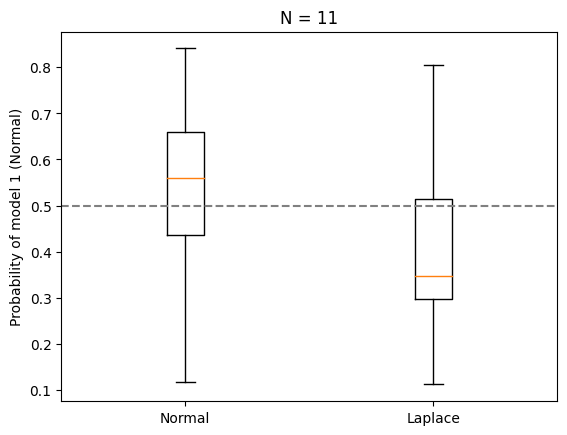

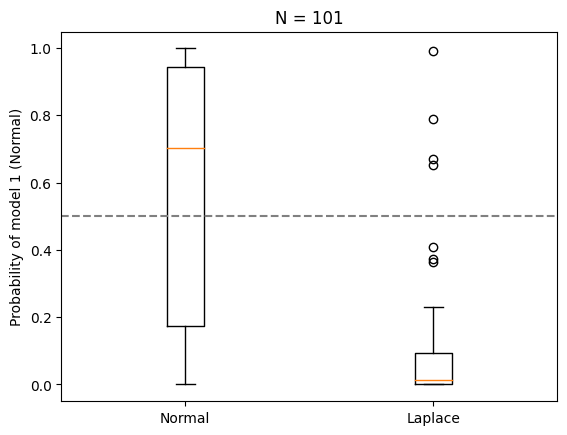

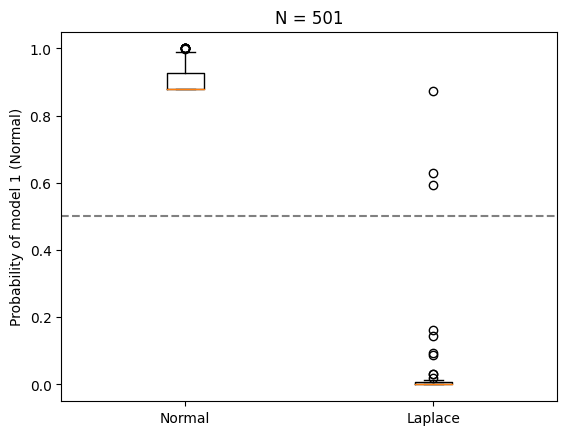

In [259]:
for i,n in enumerate([11,101,501]):
    plt.boxplot([np.exp(Norm_N[i])/(1+np.exp(Norm_N[i])),np.exp(Laplace_N[i])/(1+np.exp(Laplace_N[i]))],labels=["Normal","Laplace"])
    plt.title("N = {}".format(n))
    plt.ylabel("Probability of model 1 (Normal)")
    plt.axhline(0.5,color="grey",linestyle="--")
    plt.show()

In [13]:
from RobustGibbsObject.Model import *

In [25]:
print([1,2,3])

[1, 2, 3]


NameError: name 'B_Norm_N11' is not defined

In [ ]:
-1.52568223
med = 0.012740346488012566 
MAD = 0.677051606168922
-3.82185556
med = -0.019637866731140912 
MAD = 0.6577140339864237
-3.33783493
med = -0.021889468048087536 
MAD = 0.6536980647599903
-5.64911164
med = -0.05194153994878099 
MAD = 0.6563315943288421


In [192]:
# B_Norm_N, B_Laplace_N = [[],[],[]],[[],[],[]]
# ABC_Norm_N, ABC_Laplace_N = [[],[],[]],[[],[],[]]

T=10000
for i in tqdm(range(20)):
    for j,N in enumerate([11,101,1001]):
    # a_norm_n,a_lp_n = [],[]
    # b_norm_n,b_lp_n = [],[]
    
        X_norm = np.random.normal(0,1,N)
        med_norm,MAD_norm = np.median(X_norm),median_abs_deviation(X_norm)
        print("Norm: med = {} MAD = {}".format(med_norm,MAD_norm))
        ABC_Norm_N[j].append(np.log(ABC_Model_Paper(T,N,med_norm,MAD_norm)["BF"]))
        MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_norm,MAD_norm,List_X = True,verbose=False)
        MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_norm,MAD_norm,List_X = True,verbose=False)
        X_Normal,X_Laplace = np.array(MCMC_norm["X"][1:]),np.array(MCMC_laplace["X"][1:])
        mu_Normal, mu_Laplace= np.array(MCMC_norm["chains"]["loc"]),np.array(MCMC_laplace["chains"]["loc"])
        ratio_num = -np.array([log_ratio_normal_laplace(X_Laplace[i],mu_Laplace[i]) for i in range(len(X_Laplace))])
        ratio_den = np.array([log_ratio_normal_laplace(X_Normal[i],mu_Normal[i]) for i in range(len(X_Normal))])
        B_Norm_N[j].append(logBF_logsumexp_fixedpoint(ratio_num,ratio_den))
        
        print("LogBF = {}".format(B_Norm_N[j][-1]))
        
        X_lp = np.random.laplace(0,1/np.sqrt(2),N)
        med_lp,MAD_lp = np.median(X_lp),median_abs_deviation(X_lp)
        print("Laplace: med = {} MAD = {}".format(med_lp,MAD_lp))
        ABC_Laplace_N[j].append(np.log(ABC_Model_Paper(T,N,med_lp,MAD_lp)["BF"]))
        MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_lp,MAD_lp,List_X = True,verbose=False)
        MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med_lp,MAD_lp,List_X = True,verbose=False)
        X_Normal,X_Laplace = np.array(MCMC_norm["X"][1:]),np.array(MCMC_laplace["X"][1:])
        mu_Normal, mu_Laplace= np.array(MCMC_norm["chains"]["loc"]),np.array(MCMC_laplace["chains"]["loc"])
        ratio_num = -np.array([log_ratio_normal_laplace(X_Laplace[i],mu_Laplace[i]) for i in range(len(X_Laplace))])
        ratio_den = np.array([log_ratio_normal_laplace(X_Normal[i],mu_Normal[i]) for i in range(len(X_Normal))])
        B_Laplace_N[j].append(logBF_logsumexp_fixedpoint(ratio_num,ratio_den))
        
        print("LogBF = {}".format(B_Laplace_N[j][-1]))
        



  0%|          | 0/20 [00:00<?, ?it/s]

Norm: med = -0.45885153182673877 MAD = 0.2859946546952083
Model1: 28.00%, Model2: 72.00%
LogBF = -0.6945020581423437
Laplace: med = 0.08457918697784775 MAD = 0.786920724005435
Model1: 65.00%, Model2: 35.00%
LogBF = 0.5734290078496632
Norm: med = -0.05186291454953168 MAD = 0.695648828397734
Model1: 93.00%, Model2: 7.00%
LogBF = 1.9665708446572179
Laplace: med = -0.022734689087175936 MAD = 0.5515754256406581
Model1: 35.00%, Model2: 65.00%
LogBF = 0.033796851192156974
Norm: med = 0.012740346488012566 MAD = 0.677051606168922
Model1: 100.00%, Model2: 0.00%
LogBF = -1.5256822316508973
Laplace: med = -0.01186016235022572 MAD = 0.5397980514174853
Model1: 1.00%, Model2: 99.00%


  5%|▌         | 1/20 [02:28<47:06, 148.75s/it]

LogBF = -32.75082369513527
Norm: med = 0.4482543941426088 MAD = 0.28978956617354545
Model1: 23.00%, Model2: 77.00%
LogBF = -0.7649867591186627
Laplace: med = 0.004820119282537421 MAD = 0.3196950544716083
Model1: 32.00%, Model2: 68.00%
LogBF = -0.5965455246028735
Norm: med = 0.30199332643347504 MAD = 0.7561990522904833
Model1: 99.00%, Model2: 1.00%
LogBF = 2.5709525989695003
Laplace: med = 0.05264404072035969 MAD = 0.43083733718310036
Model1: 2.00%, Model2: 98.00%
LogBF = -5.985386241843597
Norm: med = 0.026673491839694086 MAD = 0.6614044556471397
Model1: 100.00%, Model2: 0.00%
LogBF = 17.04380742666545
Laplace: med = 0.037571295438954856 MAD = 0.47473792496328804
Model1: 0.00%, Model2: 100.00%


/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
 10%|█         | 2/20 [04:57<44:40, 148.94s/it]

LogBF = -60.30434546805744
Norm: med = 0.22622528267562392 MAD = 0.5489409291016691
Model1: 46.00%, Model2: 54.00%
LogBF = 0.10359503973049111
Laplace: med = 0.08005791883181977 MAD = 0.7195088174238939
Model1: 66.00%, Model2: 34.00%
LogBF = 0.5213887209004782
Norm: med = -0.0745802517721233 MAD = 0.8055633125184674
Model1: 98.00%, Model2: 2.00%
LogBF = 6.001693849266117
Laplace: med = 0.05588498930163149 MAD = 0.6227449296695616
Model1: 75.00%, Model2: 25.00%
LogBF = -0.4937462768104841
Norm: med = -0.019637866731140912 MAD = 0.6577140339864237
Model1: 100.00%, Model2: 0.00%
LogBF = -3.821855564835534
Laplace: med = -0.03908030350679978 MAD = 0.47719600386433736
Model1: 0.00%, Model2: 100.00%


 15%|█▌        | 3/20 [07:26<42:10, 148.83s/it]

LogBF = -43.36645676569311
Norm: med = -0.6906966182722528 MAD = 0.693411890541001
Model1: 58.00%, Model2: 42.00%
LogBF = 0.6897503342642742
Laplace: med = 0.1342587653952227 MAD = 0.2819291304196198
Model1: 23.00%, Model2: 77.00%
LogBF = -0.2864211605142567
Norm: med = -0.05353513695489836 MAD = 0.6089411169857649
Model1: 68.00%, Model2: 32.00%
LogBF = 0.21118669668388018
Laplace: med = 0.07149052653901405 MAD = 0.5181417094863577
Model1: 15.00%, Model2: 85.00%
LogBF = -1.3660164961077608
Norm: med = -0.021889468048087536 MAD = 0.6536980647599903
Model1: 100.00%, Model2: 0.00%
LogBF = -3.3378349266263427
Laplace: med = -0.001135818565091037 MAD = 0.475039048743132
Model1: 0.00%, Model2: 100.00%


 20%|██        | 4/20 [09:55<39:39, 148.74s/it]

LogBF = -45.66732304988254
Norm: med = -0.26939163941906386 MAD = 1.0891888709782864
Model1: 75.00%, Model2: 25.00%
LogBF = 0.07621026761716018
Laplace: med = 0.30199947090800877 MAD = 0.5346701803121867
Model1: 60.00%, Model2: 40.00%
LogBF = -0.4837745386774424
Norm: med = -0.04316164462310978 MAD = 0.6702442519970279
Model1: 92.00%, Model2: 8.00%
LogBF = 4.022027570826355
Laplace: med = -0.037728334669571865 MAD = 0.5466118454575477
Model1: 31.00%, Model2: 69.00%
LogBF = -0.7539377491629962
Norm: med = -0.05194153994878099 MAD = 0.6563315943288421
Model1: 100.00%, Model2: 0.00%
LogBF = -5.6491116354618685
Laplace: med = 0.009165705561054583 MAD = 0.46860692200086007
Model1: 0.00%, Model2: 100.00%


 25%|██▌       | 5/20 [12:24<37:13, 148.92s/it]

LogBF = -42.44589803156718
Norm: med = 0.04576211012578924 MAD = 0.43508272775452933
Model1: 42.00%, Model2: 58.00%
LogBF = -0.21570733057610011
Laplace: med = -0.03313953323061185 MAD = 0.3530422415677921
Model1: 40.00%, Model2: 60.00%
LogBF = -0.8547286561045668
Norm: med = -0.05451950794364569 MAD = 0.6958148699980947
Model1: 95.00%, Model2: 5.00%
LogBF = 4.756118334013975
Laplace: med = 0.058290006427895204 MAD = 0.421349838117148
Model1: 0.00%, Model2: 100.00%
LogBF = -5.6448375516832705
Norm: med = 0.03112947677106855 MAD = 0.6910268274149517
Model1: 100.00%, Model2: 0.00%
LogBF = 17.01086720803683
Laplace: med = 0.017396624953633616 MAD = 0.515663778754044
Model1: 0.00%, Model2: 100.00%


 30%|███       | 6/20 [14:53<34:45, 148.97s/it]

LogBF = -34.636436247598986
Norm: med = 0.07072975740989211 MAD = 0.37021097721510465
Model1: 40.00%, Model2: 60.00%
LogBF = -0.23687424946758284
Laplace: med = -0.7144467440192372 MAD = 0.9109603799887569
Model1: 77.00%, Model2: 23.00%
LogBF = 0.976822026358439
Norm: med = -0.15040528604160747 MAD = 0.7635603140228817
Model1: 100.00%, Model2: 0.00%
LogBF = 5.168979889842058
Laplace: med = 0.029148130469310682 MAD = 0.49636200243736955
Model1: 11.00%, Model2: 89.00%
LogBF = -1.8788033821421084
Norm: med = 0.0047679162971386675 MAD = 0.6809592721926588
Model1: 100.00%, Model2: 0.00%
LogBF = 18.848092354180608
Laplace: med = -0.0035485610901846826 MAD = 0.4921942848137602
Model1: 0.00%, Model2: 100.00%


 35%|███▌      | 7/20 [17:22<32:17, 149.07s/it]

LogBF = -36.522742203342034
Norm: med = -0.48450899925062124 MAD = 0.2889187418824679
Model1: 25.00%, Model2: 75.00%
LogBF = -1.2834215095800519
Laplace: med = 0.09929934895236177 MAD = 0.3952141770987568
Model1: 38.00%, Model2: 62.00%
LogBF = -1.6963173143359345
Norm: med = -0.022426598283312258 MAD = 0.8520878138049461
Model1: 99.00%, Model2: 1.00%
LogBF = 4.8047980349533
Laplace: med = 0.10915103734652486 MAD = 0.41241851055332346
Model1: 1.00%, Model2: 99.00%
LogBF = -8.103960519891718
Norm: med = -0.05297002811333464 MAD = 0.6738961221272518
Model1: 100.00%, Model2: 0.00%
LogBF = 22.854491417996755
Laplace: med = -0.014141263574351848 MAD = 0.48304686353600695
Model1: 0.00%, Model2: 100.00%


 40%|████      | 8/20 [19:52<29:52, 149.34s/it]

LogBF = -37.654035631298584
Norm: med = -0.2139230271751875 MAD = 0.6200260579494971
Model1: 56.00%, Model2: 44.00%
LogBF = -0.31508112808891764
Laplace: med = -0.23187126170244857 MAD = 0.5226271081138483
Model1: 49.00%, Model2: 51.00%
LogBF = -0.08849876920863196
Norm: med = 0.0754544087320368 MAD = 0.6281239420541271
Model1: 71.00%, Model2: 29.00%
LogBF = 1.6269070338371867
Laplace: med = 0.15992805110942285 MAD = 0.6951754810925431
Model1: 95.00%, Model2: 5.00%
LogBF = -0.08271796181828828
Norm: med = 0.047455156159075286 MAD = 0.6709946173628205
Model1: 100.00%, Model2: 0.00%
LogBF = 13.851602207586517
Laplace: med = -0.01684738276391656 MAD = 0.4719782229520832
Model1: 0.00%, Model2: 100.00%


 45%|████▌     | 9/20 [22:22<27:23, 149.43s/it]

LogBF = -44.813447601272976
Norm: med = 0.5352152400904607 MAD = 1.1940911052607022
Model1: 72.00%, Model2: 28.00%
LogBF = -0.7412179652763461
Laplace: med = -0.1533226553720219 MAD = 0.23811043211277585
Model1: 25.00%, Model2: 75.00%
LogBF = -0.6327513318400976
Norm: med = -0.029538027065997226 MAD = 0.7454990801258604
Model1: 96.00%, Model2: 4.00%
LogBF = -1.7611808890067193
Laplace: med = 0.017654280783201907 MAD = 0.5228699457584932
Model1: 14.00%, Model2: 86.00%
LogBF = -0.8400925500110494
Norm: med = 0.008324324354904098 MAD = 0.6756379778964549
Model1: 100.00%, Model2: 0.00%
LogBF = 17.749118210410924
Laplace: med = -0.021776958618627718 MAD = 0.4917466398251077
Model1: 0.00%, Model2: 100.00%


 50%|█████     | 10/20 [24:56<25:10, 151.02s/it]

LogBF = -36.70924112855943
Norm: med = -0.9074768093399777 MAD = 0.3755405671930956
Model1: 40.00%, Model2: 60.00%
LogBF = -0.17602824346086843
Laplace: med = 0.278066637490983 MAD = 0.5016504364299943
Model1: 51.00%, Model2: 49.00%
LogBF = 0.2561066285310938
Norm: med = -0.10218177304930436 MAD = 0.5839078470957653
Model1: 56.00%, Model2: 44.00%
LogBF = -0.7298832245581967
Laplace: med = 0.038611102168980296 MAD = 0.570501711821983
Model1: 45.00%, Model2: 55.00%
LogBF = -1.2788374701729517
Norm: med = -0.046743862835471564 MAD = 0.6593226166858663
Model1: 100.00%, Model2: 0.00%
LogBF = 14.871117907588618
Laplace: med = 0.04038688352820472 MAD = 0.5080685239374831
Model1: 0.00%, Model2: 100.00%


 55%|█████▌    | 11/20 [27:26<22:36, 150.70s/it]

LogBF = -19.219253725441927
Norm: med = -0.4057761677351743 MAD = 0.30614152484353413
Model1: 30.00%, Model2: 70.00%
LogBF = -0.9772341842814463
Laplace: med = -0.38792669636119465 MAD = 0.36051157933571437
Model1: 31.00%, Model2: 69.00%
LogBF = -0.1827031421674213
Norm: med = -0.015130063864052079 MAD = 0.6432689969843897
Model1: 78.00%, Model2: 22.00%
LogBF = 1.4923172105634248
Laplace: med = -0.02317232670723967 MAD = 0.5639181705548367
Model1: 52.00%, Model2: 48.00%
LogBF = -4.073382087734315
Norm: med = -0.021161766881765704 MAD = 0.6777840811012028
Model1: 100.00%, Model2: 0.00%
LogBF = 22.127941223419562
Laplace: med = -0.007894500215036753 MAD = 0.49632739268289056
Model1: 0.00%, Model2: 100.00%


 60%|██████    | 12/20 [29:55<20:00, 150.12s/it]

LogBF = -47.529209556228565
Norm: med = 0.04892975562331589 MAD = 0.4438269518227338
Model1: 47.00%, Model2: 53.00%
LogBF = -0.3289385272141535
Laplace: med = 0.007979340304524525 MAD = 0.7970240099230672
Model1: 72.00%, Model2: 28.00%
LogBF = 0.5270089080228523
Norm: med = 0.14937488833215584 MAD = 0.7135928633584457
Model1: 97.00%, Model2: 3.00%
LogBF = 2.6926805346447376
Laplace: med = 0.16354055579569748 MAD = 0.5086805492543633
Model1: 16.00%, Model2: 84.00%
LogBF = -1.2467886083042343
Norm: med = 0.0008035418510387484 MAD = 0.6555523797749948
Model1: 100.00%, Model2: 0.00%
LogBF = 1.406796428490826
Laplace: med = 0.001457418923556032 MAD = 0.47607941929754904
Model1: 0.00%, Model2: 100.00%


 65%|██████▌   | 13/20 [32:27<17:35, 150.72s/it]

LogBF = -43.280976010867086
Norm: med = 0.23070065461241313 MAD = 1.0146873860445633
Model1: 78.00%, Model2: 22.00%
LogBF = 1.1721449311197267
Laplace: med = -0.15653490332873632 MAD = 0.4496090015299547
Model1: 46.00%, Model2: 54.00%
LogBF = -0.31391791680726333
Norm: med = -0.07905729658824474 MAD = 0.6095503919655835
Model1: 71.00%, Model2: 29.00%
LogBF = -0.38296334350283745
Laplace: med = 0.02442868627411559 MAD = 0.4532878694059132
Model1: 2.00%, Model2: 98.00%
LogBF = -6.149326288275032
Norm: med = 0.010748060556404537 MAD = 0.6744849495127085
Model1: 100.00%, Model2: 0.00%
LogBF = 11.904734800311854
Laplace: med = 0.02031919183971034 MAD = 0.5020134307464686
Model1: 0.00%, Model2: 100.00%


 70%|███████   | 14/20 [35:00<15:07, 151.28s/it]

LogBF = -36.9495952908476
Norm: med = 0.07474028318331936 MAD = 0.3954614119113122
Model1: 38.00%, Model2: 62.00%
LogBF = -0.632045727951723
Laplace: med = 0.3825222596168335 MAD = 0.6019547955183211
Model1: 50.00%, Model2: 50.00%
LogBF = 0.3365269965627157
Norm: med = 0.19048439634981532 MAD = 0.657159586391908
Model1: 87.00%, Model2: 13.00%
LogBF = 3.5373884035269922
Laplace: med = -0.06963492575306293 MAD = 0.42972570339355465
Model1: 0.00%, Model2: 100.00%
LogBF = -3.617672436946987
Norm: med = 0.015707591732885287 MAD = 0.6570828349635806
Model1: 100.00%, Model2: 0.00%
LogBF = 7.25532805685933
Laplace: med = 0.012103215735128023 MAD = 0.5001342281108149
Model1: 0.00%, Model2: 100.00%


 75%|███████▌  | 15/20 [37:28<12:31, 150.38s/it]

LogBF = -29.848992224866212
Norm: med = -0.6261869957298055 MAD = 0.45843447194447823
Model1: 46.00%, Model2: 54.00%
LogBF = 0.0435581139447893
Laplace: med = -0.20415209102895696 MAD = 0.8194747010255141
Model1: 68.00%, Model2: 32.00%
LogBF = 0.6868810982866679
Norm: med = 0.15468613572444326 MAD = 0.6716553515474442
Model1: 86.00%, Model2: 14.00%
LogBF = 2.7413501854272253
Laplace: med = -0.07961299036847479 MAD = 0.5077028873913355
Model1: 15.00%, Model2: 85.00%
LogBF = -3.790361463765774
Norm: med = -0.1394275306174721 MAD = 0.6645623634217905
Model1: 100.00%, Model2: 0.00%
LogBF = 13.143217560147066
Laplace: med = -0.011283553265434013 MAD = 0.4641059428595379
Model1: 0.00%, Model2: 100.00%


 80%|████████  | 16/20 [39:56<09:58, 149.74s/it]

LogBF = -54.22377457123386
Norm: med = -0.2190003979014689 MAD = 0.5867295238405179
Model1: 48.00%, Model2: 52.00%
LogBF = -0.23351103481110524
Laplace: med = 0.016637606046888048 MAD = 0.2627284500786584
Model1: 27.00%, Model2: 73.00%
LogBF = -0.6450889348292526
Norm: med = -0.031331606798438806 MAD = 0.6478290234003677
Model1: 82.00%, Model2: 18.00%
LogBF = 2.2268787845410603
Laplace: med = -0.10223517110198546 MAD = 0.5460529790643993
Model1: 38.00%, Model2: 62.00%
LogBF = -2.8532993914467912
Norm: med = 0.02278064450068726 MAD = 0.7180851529353846
Model1: 100.00%, Model2: 0.00%
LogBF = 17.645596693753074
Laplace: med = 0.013061866115078806 MAD = 0.48842331667768196
Model1: 0.00%, Model2: 100.00%


 85%|████████▌ | 17/20 [42:25<07:28, 149.46s/it]

LogBF = -47.903213626645226
Norm: med = -0.42240501209446335 MAD = 0.7570514722045165
Model1: 64.00%, Model2: 36.00%
LogBF = 0.7130130898636885
Laplace: med = -0.16253444303761178 MAD = 0.4852493977338314
Model1: 48.00%, Model2: 52.00%
LogBF = -0.11566861059369771
Norm: med = 0.09249168629535534 MAD = 0.6876810471960616
Model1: 92.00%, Model2: 8.00%
LogBF = 4.474077195965353
Laplace: med = 0.19197030826898043 MAD = 0.42092525482725357
Model1: 3.00%, Model2: 97.00%
LogBF = -2.981120853812274
Norm: med = -0.01702387412318565 MAD = 0.6822960582274671
Model1: 100.00%, Model2: 0.00%
LogBF = 16.242994073943986
Laplace: med = -0.03730140465282214 MAD = 0.47848259785885616
Model1: 0.00%, Model2: 100.00%


 90%|█████████ | 18/20 [44:54<04:58, 149.18s/it]

LogBF = -46.04757193328154
Norm: med = 0.34395664842472695 MAD = 0.241155489044526
Model1: 27.00%, Model2: 73.00%
LogBF = -0.6724993982270272
Laplace: med = 0.12507055752424492 MAD = 0.28614638719360475
Model1: 28.00%, Model2: 72.00%
LogBF = -0.9059898502180562
Norm: med = 0.05182972408193511 MAD = 0.7688883268761649
Model1: 94.00%, Model2: 6.00%
LogBF = 7.633057415733245
Laplace: med = -0.06552570696352396 MAD = 0.5059256806202906
Model1: 14.00%, Model2: 86.00%
LogBF = -1.9556037062147118
Norm: med = -0.05240556268446344 MAD = 0.6908216129838336
Model1: 100.00%, Model2: 0.00%
LogBF = 21.220527934263682
Laplace: med = -0.014914952574422935 MAD = 0.4771159932308492
Model1: 0.00%, Model2: 100.00%


 95%|█████████▌| 19/20 [47:23<02:29, 149.13s/it]

LogBF = -36.696430188706906
Norm: med = 0.1835996345692879 MAD = 0.6283505499755357
Model1: 57.00%, Model2: 43.00%
LogBF = -1.4609908311927047
Laplace: med = 0.18052317456821543 MAD = 0.8160529028242379
Model1: 66.00%, Model2: 34.00%
LogBF = 0.8125059139404589
Norm: med = -0.029090884305977036 MAD = 0.7840557731149707
Model1: 98.00%, Model2: 2.00%
LogBF = 5.297759982073449
Laplace: med = 0.09158924539475849 MAD = 0.5416141689895042
Model1: 29.00%, Model2: 71.00%
LogBF = -0.5929607394976903
Norm: med = -0.01596810547100565 MAD = 0.6539570912502096
Model1: 100.00%, Model2: 0.00%
LogBF = 2.12742586951696
Laplace: med = -0.030082611797027103 MAD = 0.5071000509622193
Model1: 0.00%, Model2: 100.00%


100%|██████████| 20/20 [49:52<00:00, 149.64s/it]

LogBF = -33.91292746712227


In [163]:
len(B_Norm_N[0]),len(B_Norm_N[1]),len(B_Norm_N[2])

(20, 20, 20)

In [164]:
len(B_Laplace_N[0]),len(B_Laplace_N[1]),len(B_Laplace_N[2])

(20, 20, 19)

In [160]:
len(B_Norm_N3[0]),len(B_Norm_N3[1]),len(B_Norm_N3[2]),len(B_Norm_N3[3])

(30, 11, 11, 10)

In [161]:
len(ABC_Norm_N3[0]),len(ABC_Norm_N3[1]),len(ABC_Norm_N3[2]),len(ABC_Norm_N3[3])

IndexError: list index out of range

In [24]:
len(B_Norm_N3[1]),len(B_Norm_N3[2]),len(B_Norm_N3[3])

(11, 11, 10)

In [322]:
print("SHapes : ABC_Norm = {} B_Norm = {}".format([np.array(ABC_Norm_N2[i]).shape for i in range(3)], [np.array(B_Norm_N2[i]).shape for i in range(3)]))

SHapes : ABC_Norm = [(100,), (100,), (96,)] B_Norm = [(100,), (100,), (95,)]


### ABC vs Bridge

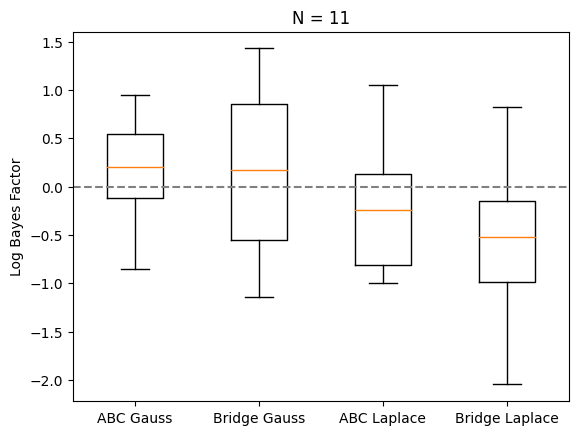

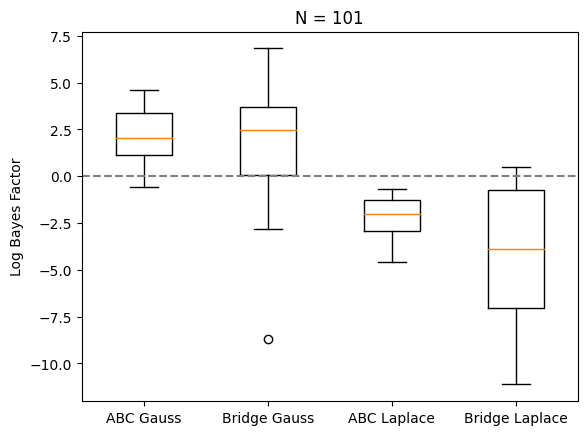

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


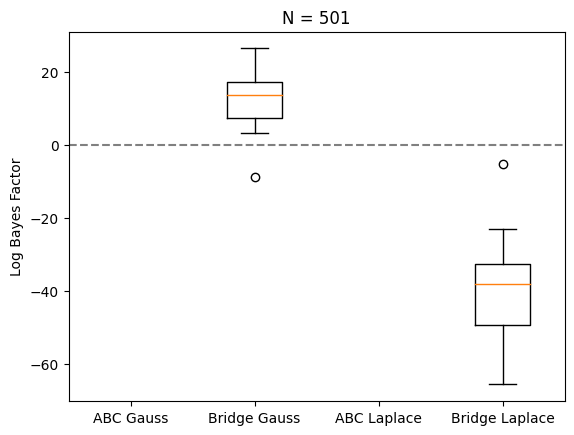

IndexError: list index out of range

In [188]:
for j,N in enumerate([11,101,501,1001]):
    plt.boxplot([ABC_Norm_N[j],B_Norm_N[j],ABC_Laplace_N[j],B_Laplace_N[j]],labels=["ABC Gauss","Bridge Gauss","ABC Laplace","Bridge Laplace"])
    plt.title("N = {}".format(N))
    plt.ylabel("Log Bayes Factor")
    plt.axhline(0,color="grey",linestyle="--")
    plt.show()


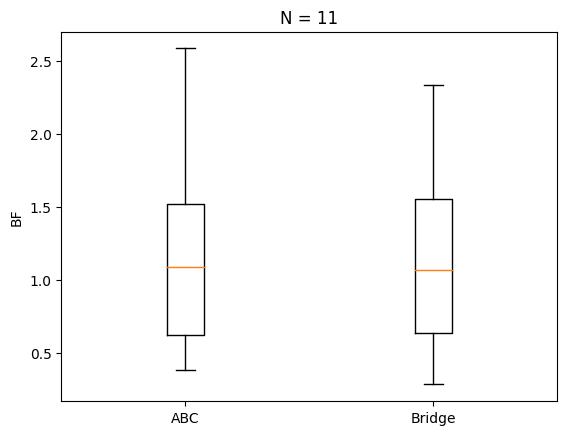

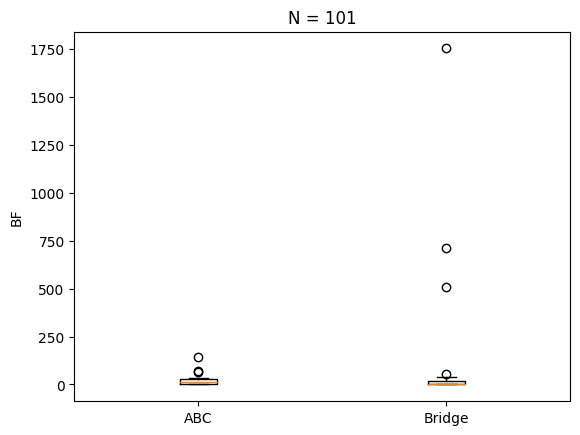

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


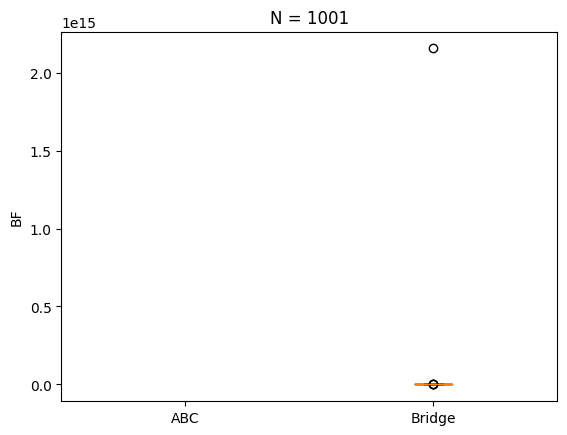

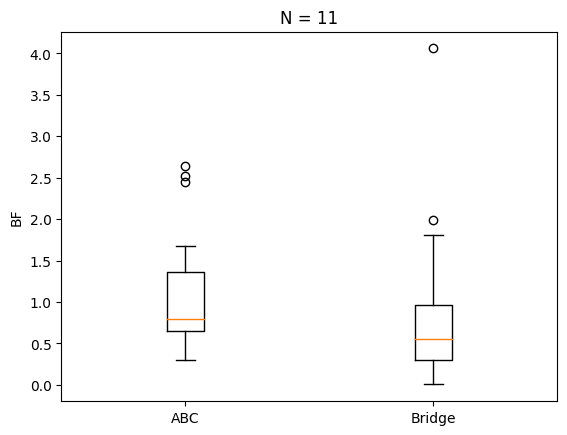

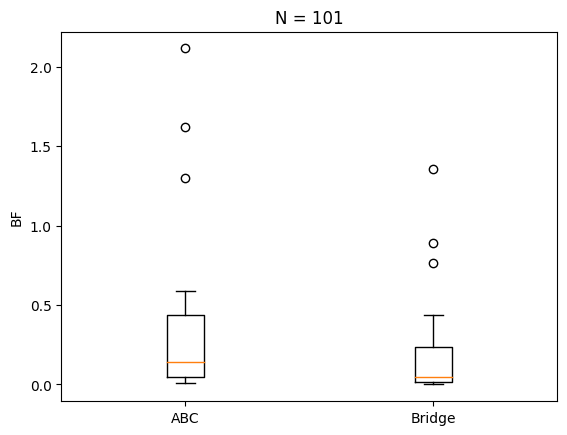

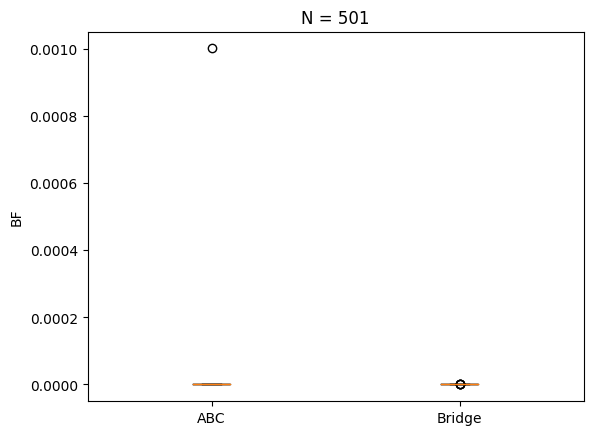

IndexError: list index out of range

In [166]:
for j,N in enumerate([11,101,1001]):
    plt.boxplot([np.exp(ABC_Norm_N[j]),np.exp(B_Norm_N[j])],labels=["ABC","Bridge"])
    plt.title("N = {}".format(N))
    plt.ylabel("BF")
    plt.show()
for j,N in enumerate([11,101,501,1001]):
    plt.boxplot([np.exp(ABC_Laplace_N[j]),np.exp(B_Laplace_N[j])],labels=["ABC","Bridge"])
    plt.title("N = {}".format(N))
    plt.ylabel("BF")
    plt.show()

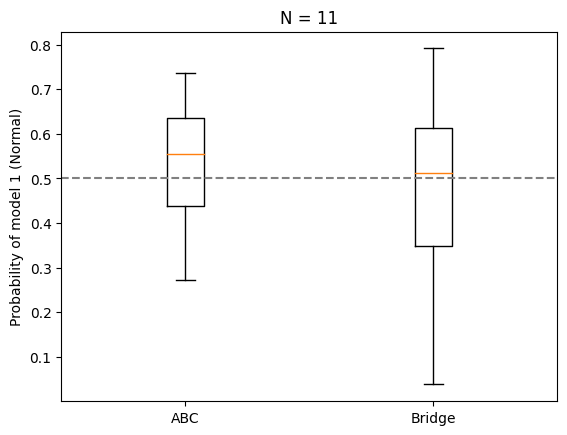

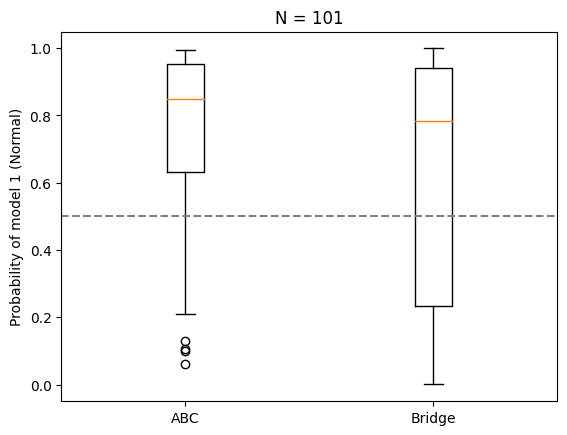

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


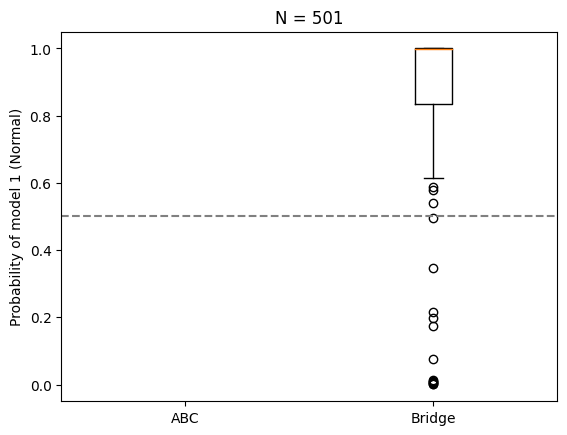

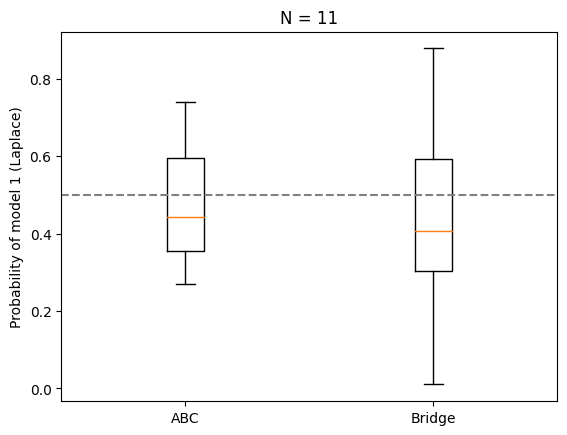

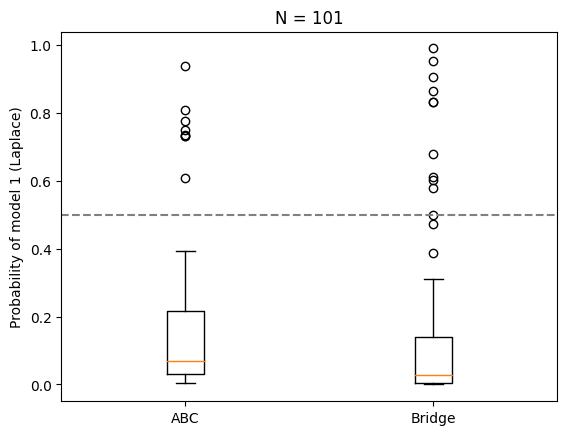

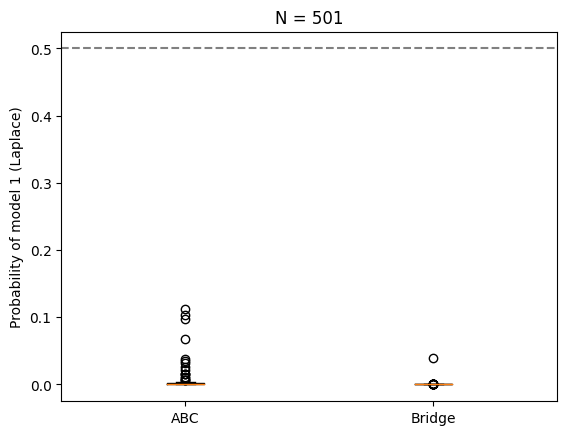

In [328]:
for j,N in enumerate([11,101,501]):
    plt.boxplot([np.exp(ABC_Norm_N2[j])/(1+np.exp(ABC_Norm_N2[j])),np.exp(B_Norm_N2[j])/(1+np.exp(B_Norm_N2[j]))],labels=["ABC","Bridge"])
    plt.title("N = {}".format(N))
    plt.ylabel("Probability of model 1 (Normal)")
    plt.axhline(0.5,color="grey",linestyle="--")
    plt.show()
for j,N in enumerate([11,101,501]):
    plt.boxplot([np.exp(ABC_Laplace_N2[j])/(1+np.exp(ABC_Laplace_N2[j])),np.exp(B_Laplace_N2[j])/(1+np.exp(B_Laplace_N2[j]))],labels=["ABC","Bridge"])
    plt.title("N = {}".format(N))
    plt.ylabel("Probability of model 1 (Laplace)")
    plt.axhline(0.5,color="grey",linestyle="--")
    plt.show()

### Bridge

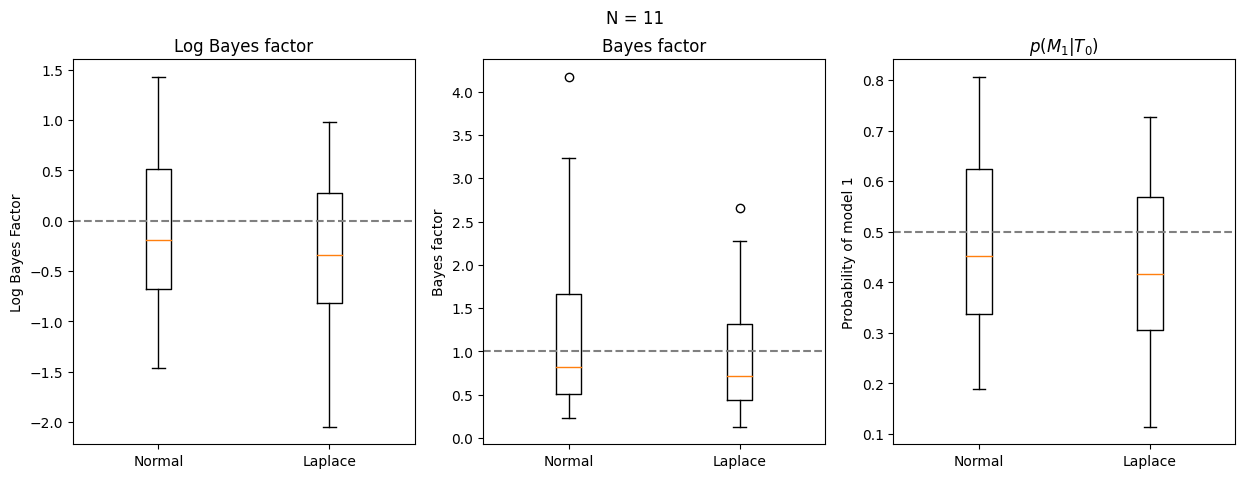

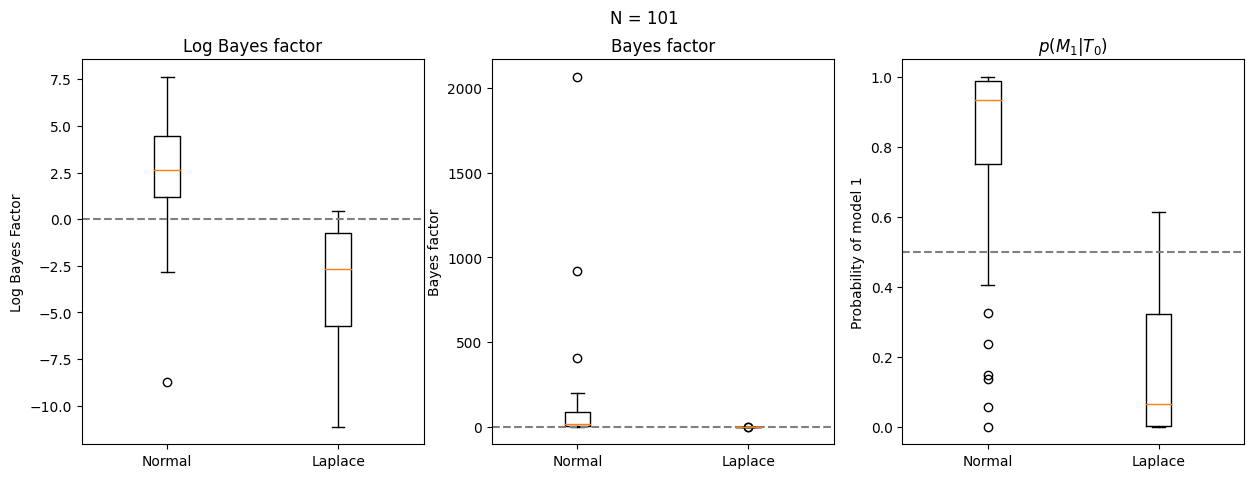

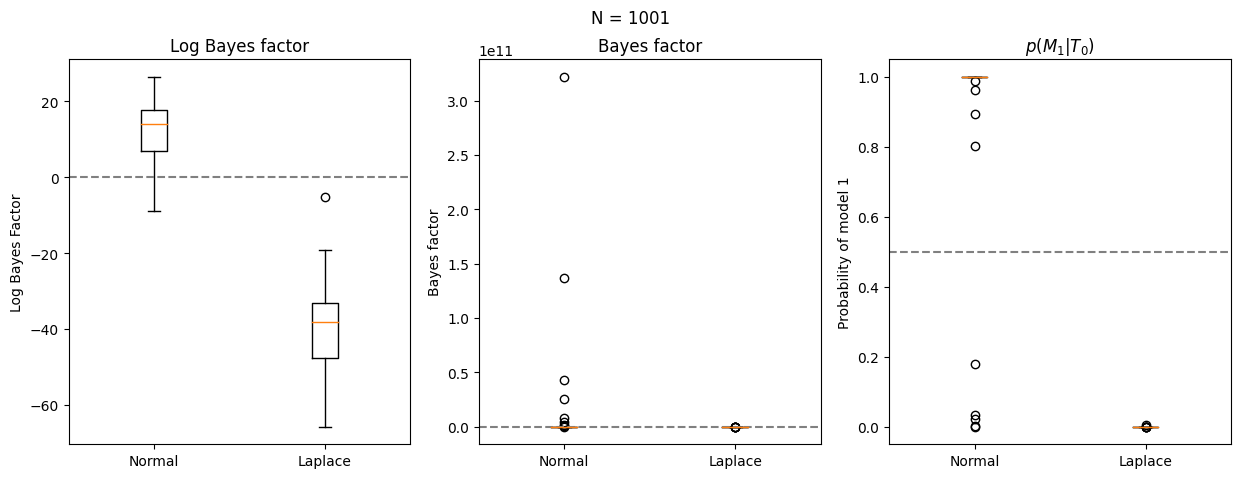

In [193]:
for j,N in enumerate([11,101,1001]):
    f,ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].boxplot([B_Norm_N[j],B_Laplace_N[j]],labels=["Normal","Laplace"])
    ax[0].set_title("Log Bayes factor")
    ax[0].set_ylabel("Log Bayes Factor")
    ax[0].axhline(0,color="grey",linestyle="--")
    
    ax[1].boxplot([np.exp(B_Norm_N[j]),np.exp(B_Laplace_N[j])],labels=["Normal","Laplace"])
    ax[1].set_title("Bayes factor")
    ax[1].set_ylabel("Bayes factor")
    ax[1].axhline(1,color="grey",linestyle="--")
    
    ax[2].boxplot([np.exp(B_Norm_N[j])/(1+np.exp(B_Norm_N[j])),np.exp(B_Laplace_N[j])/(1+np.exp(B_Laplace_N[j]))],labels=["Normal","Laplace"])
    ax[2].set_title("$p(M_1|T_0)$")
    ax[2].set_ylabel("Probability of model 1")
    ax[2].axhline(0.5,color="grey",linestyle="--")
    f.suptitle("N = {}".format(N))

In [207]:
test = np.array(B_Norm_N[-1])
test[np.where(np.array(B_Norm_N[-1])<0)[0]]

array([-8.83516139, -1.52568223, -3.82185556, -3.33783493, -5.64911164])

# Verifications

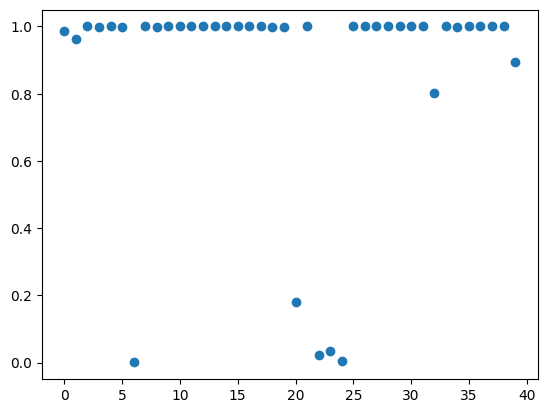

TypeError: list indices must be integers or slices, not tuple

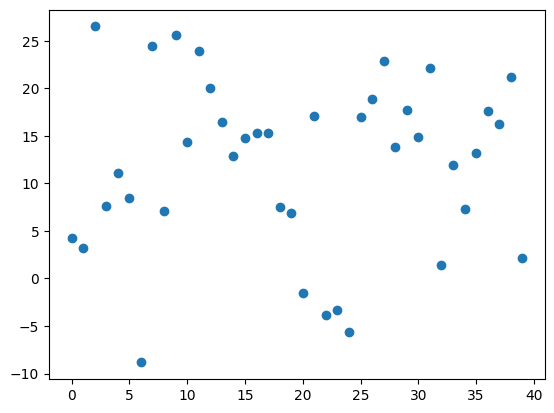

In [203]:
plt.scatter(range(40),np.exp(B_Norm_N[-1])/(1+np.exp(B_Norm_N[-1])))
plt.show()
plt.scatter(range(40),B_Norm_N[-1])
B_Norm_N[-1][np.where(np.array(B_Norm_N[-1])<0)]

In [ ]:
-1.52568223
med = 0.012740346488012566 
MAD = 0.677051606168922
-3.82185556
med = -0.019637866731140912 
MAD = 0.6577140339864237
-3.33783493
med = -0.021889468048087536 
MAD = 0.6536980647599903
-5.64911164
med = -0.05194153994878099 
MAD = 0.6563315943288421

In [232]:
LBF_MAD=[]
med=0
N=1001
T = 20000
for MAD in np.linspace(np.log(2)/np.sqrt(2),norm.ppf(0.75),10):
    MCMC_Norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med,MAD,List_X = True,verbose=True)
    MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med,MAD,List_X = True,verbose=True)


    theta_norm = np.array(MCMC_Norm["chains"]["loc"])
    theta_laplace = np.array(MCMC_laplace["chains"]["loc"])
    X_norm = np.array(MCMC_Norm["X"][1:])
    X_laplace = np.array(MCMC_laplace["X"][1:])

    ratio_num = -np.array([log_ratio_normal_laplace(X_laplace[i],theta_laplace[i]) for i in range(len(X_laplace))])
    ratio_den = np.array([log_ratio_normal_laplace(X_norm[i],theta_norm[i]) for i in range(len(X_norm))])
    logBF_test = logBF_logsumexp_fixedpoint(ratio_num,ratio_den)
    LBF_MAD.append(logBF_test)

    
    

100%|██████████| 10000/10000 [00:16<00:00, 590.15it/s]


Acceptation rates MH : loc = 35.54% 


100%|██████████| 10000/10000 [00:17<00:00, 580.06it/s]


Acceptation rates MH : loc = 26.99% 


100%|██████████| 10000/10000 [00:16<00:00, 601.06it/s]


Acceptation rates MH : loc = 35.75% 


100%|██████████| 10000/10000 [00:17<00:00, 565.80it/s]


Acceptation rates MH : loc = 27.29% 


100%|██████████| 10000/10000 [00:16<00:00, 590.57it/s]


Acceptation rates MH : loc = 35.83% 


100%|██████████| 10000/10000 [00:17<00:00, 579.75it/s]


Acceptation rates MH : loc = 26.40% 


100%|██████████| 10000/10000 [00:16<00:00, 588.95it/s]


Acceptation rates MH : loc = 35.48% 


100%|██████████| 10000/10000 [00:17<00:00, 578.82it/s]


Acceptation rates MH : loc = 28.17% 


100%|██████████| 10000/10000 [00:16<00:00, 599.55it/s]


Acceptation rates MH : loc = 36.48% 


100%|██████████| 10000/10000 [00:17<00:00, 569.60it/s]


Acceptation rates MH : loc = 28.65% 


100%|██████████| 10000/10000 [00:17<00:00, 571.99it/s]


Acceptation rates MH : loc = 36.27% 


100%|██████████| 10000/10000 [00:17<00:00, 555.59it/s]


Acceptation rates MH : loc = 29.43% 


100%|██████████| 10000/10000 [00:16<00:00, 609.47it/s]


Acceptation rates MH : loc = 35.65% 


100%|██████████| 10000/10000 [00:17<00:00, 571.96it/s]


Acceptation rates MH : loc = 30.17% 


100%|██████████| 10000/10000 [00:16<00:00, 598.61it/s]


Acceptation rates MH : loc = 36.20% 


100%|██████████| 10000/10000 [00:17<00:00, 577.00it/s]


Acceptation rates MH : loc = 28.80% 


100%|██████████| 10000/10000 [00:16<00:00, 599.87it/s]


Acceptation rates MH : loc = 35.03% 


100%|██████████| 10000/10000 [00:17<00:00, 584.94it/s]


Acceptation rates MH : loc = 29.23% 


100%|██████████| 10000/10000 [00:16<00:00, 608.22it/s]


Acceptation rates MH : loc = 35.06% 


100%|██████████| 10000/10000 [00:17<00:00, 586.36it/s]


Acceptation rates MH : loc = 30.11% 


In [230]:
np.log(2)/np.sqrt(2),norm.ppf(0.75)

(0.49012907173427356, 0.6744897501960817)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 283.78it/s]


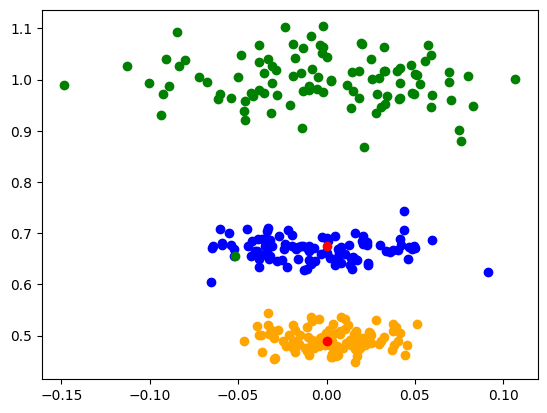

In [235]:
for _ in tqdm(range(100)):
    X = np.random.normal(0,1,1001)
    plt.scatter(np.median(X),median_abs_deviation(X),color = "blue")
    X = np.random.laplace(0,1/np.sqrt(2),1001)
    plt.scatter(np.median(X),median_abs_deviation(X),color = "orange")
    X = np.random.standard_cauchy(1001)
    plt.scatter(np.median(X),median_abs_deviation(X),color = "green")
plt.scatter(0,norm.ppf(0.75),color="red")
plt.scatter(0,np.log(2)/np.sqrt(2),color="red")
med = -0.05194153994878099 
MAD = 0.6563315943288421
plt.scatter(med,MAD,color="green")
    

## Test divergence

In [179]:
med = -0.060691500784646246 
MAD = 0.6609610351526689

In [209]:
T = 10000

In [220]:
N

1001

In [221]:
med = -0.05194153994878099 
MAD = 0.6563315943288421
T  = 10000
for _ in range(10):
    MCMC_Norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med,MAD,List_X = True,verbose=True)
    MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med,MAD,List_X = True,verbose=True)


    theta_norm = np.array(MCMC_Norm["chains"]["loc"])
    theta_laplace = np.array(MCMC_laplace["chains"]["loc"])
    X_norm = np.array(MCMC_Norm["X"][1:])
    X_laplace = np.array(MCMC_laplace["X"][1:])

    ratio_num = -np.array([log_ratio_normal_laplace(X_laplace[i],theta_laplace[i]) for i in range(len(X_laplace))])
    ratio_den = np.array([log_ratio_normal_laplace(X_norm[i],theta_norm[i]) for i in range(len(X_norm))])
    logBF_test = logBF_logsumexp_fixedpoint(ratio_num,ratio_den)
    LBF2.append(logBF_test)

100%|██████████| 5000/5000 [00:08<00:00, 592.07it/s]


Acceptation rates MH : loc = 35.64% 


100%|██████████| 5000/5000 [00:08<00:00, 588.32it/s]


Acceptation rates MH : loc = 28.90% 


100%|██████████| 5000/5000 [00:08<00:00, 607.00it/s]


Acceptation rates MH : loc = 35.90% 


100%|██████████| 5000/5000 [00:08<00:00, 585.73it/s]


Acceptation rates MH : loc = 28.74% 


100%|██████████| 5000/5000 [00:08<00:00, 597.90it/s]


Acceptation rates MH : loc = 34.64% 


100%|██████████| 5000/5000 [00:08<00:00, 563.31it/s]


Acceptation rates MH : loc = 31.58% 


100%|██████████| 5000/5000 [00:08<00:00, 605.76it/s]


Acceptation rates MH : loc = 35.68% 


100%|██████████| 5000/5000 [00:08<00:00, 568.45it/s]


Acceptation rates MH : loc = 29.08% 


100%|██████████| 5000/5000 [00:08<00:00, 610.38it/s]


Acceptation rates MH : loc = 34.72% 


100%|██████████| 5000/5000 [00:08<00:00, 594.07it/s]


Acceptation rates MH : loc = 28.94% 


100%|██████████| 5000/5000 [00:08<00:00, 556.59it/s]


Acceptation rates MH : loc = 35.58% 


100%|██████████| 5000/5000 [00:08<00:00, 559.82it/s]


Acceptation rates MH : loc = 28.44% 


100%|██████████| 5000/5000 [00:08<00:00, 594.90it/s]


Acceptation rates MH : loc = 35.08% 


100%|██████████| 5000/5000 [00:08<00:00, 571.30it/s]


Acceptation rates MH : loc = 30.66% 


100%|██████████| 5000/5000 [00:08<00:00, 591.35it/s]


Acceptation rates MH : loc = 35.50% 


100%|██████████| 5000/5000 [00:09<00:00, 547.39it/s]


Acceptation rates MH : loc = 27.06% 


100%|██████████| 5000/5000 [00:08<00:00, 604.94it/s]


Acceptation rates MH : loc = 36.18% 


100%|██████████| 5000/5000 [00:08<00:00, 589.39it/s]


Acceptation rates MH : loc = 28.86% 


100%|██████████| 5000/5000 [00:08<00:00, 599.18it/s]


Acceptation rates MH : loc = 35.46% 


100%|██████████| 5000/5000 [00:08<00:00, 584.89it/s]


Acceptation rates MH : loc = 29.82% 


{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd57100810>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd57100550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd88d608450>,
 'medians': [<matplotlib.lines.Line2D at 0x7fcd652f4750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd5b9c6d50>,
 'means': []}

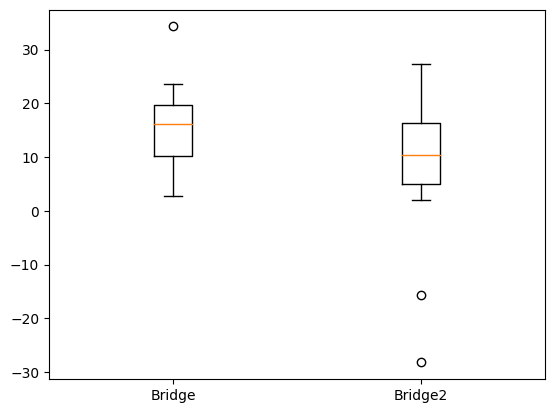

In [222]:
plt.boxplot([LBF,LBF2],labels=["Bridge","Bridge2"])

In [214]:
LBF2 = []
T=100000
for _ in range(5):
    MCMC_Norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T,N,med,MAD,List_X = True,verbose=True)
    MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T,N,med,MAD,List_X = True,verbose=True)


    theta_norm = np.array(MCMC_Norm["chains"]["loc"])
    theta_laplace = np.array(MCMC_laplace["chains"]["loc"])
    X_norm = np.array(MCMC_Norm["X"][1:])
    X_laplace = np.array(MCMC_laplace["X"][1:])

    ratio_num = -np.array([log_ratio_normal_laplace(X_laplace[i],theta_laplace[i]) for i in range(len(X_laplace))])
    ratio_den = np.array([log_ratio_normal_laplace(X_norm[i],theta_norm[i]) for i in range(len(X_norm))])
    logBF_test = logBF_logsumexp_fixedpoint(ratio_num,ratio_den)
    LBF2.append(logBF_test)

100%|██████████| 100000/100000 [02:43<00:00, 610.44it/s]


Acceptation rates MH : loc = 35.76% 


100%|██████████| 100000/100000 [02:51<00:00, 581.97it/s]


Acceptation rates MH : loc = 29.90% 


 55%|█████▌    | 55122/100000 [01:30<01:14, 606.28it/s]


KeyboardInterrupt: 

In [215]:
LBF2

[array(17.44437108)]

In [180]:
MCMC_Norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med,MAD,List_X = True,verbose=True)
MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med,MAD,List_X = True,verbose=True)



100%|██████████| 50000/50000 [01:22<00:00, 603.71it/s]


Acceptation rates MH : loc = 35.87% 


100%|██████████| 50000/50000 [01:28<00:00, 563.04it/s]

Acceptation rates MH : loc = 29.06% 


In [181]:
theta_norm = np.array(MCMC_Norm["chains"]["loc"])
theta_laplace = np.array(MCMC_laplace["chains"]["loc"])
X_norm = np.array(MCMC_Norm["X"][1:])
X_laplace = np.array(MCMC_laplace["X"][1:])

ratio_num = -np.array([log_ratio_normal_laplace(X_laplace[i],theta_laplace[i]) for i in range(len(X_laplace))])
ratio_den = np.array([log_ratio_normal_laplace(X_norm[i],theta_norm[i]) for i in range(len(X_norm))])

In [182]:
logBF_test = logBF_logsumexp_fixedpoint(ratio_num,ratio_den)
logBF_test

array(15.22231458)

# Test Mad Only

## Homemade

In [149]:
def posterior_normal_prior_normal(X,mu_0,sigma_0):
    return norm(loc = (mu_0/sigma_0**2+np.sum(X))/(1/sigma_0**2+len(X)),scale = 1/np.sqrt(1/sigma_0**2+len(X)/1**2))

In [150]:
def mu_med_MAD(T,N,med,MAD):
    Mu = []
    X = []
    for _ in tqdm(range(T)):
        X_t = np.random.normal(0,1,N)
        X_t = (X_t-np.median(X_t))/median_abs_deviation(X_t)*MAD + med
        Mu.append(posterior_normal_prior_normal(X_t,0,2).rvs(1)[0])
        X.append(X_t)
    return Mu,X
        

In [151]:
np.unique(np.median(X,axis=1)),np.unique(median_abs_deviation(X,axis=1))

(array([0.]), array([1.]))

In [152]:
def mu_MAD_only(T,N, MAD):
    Mu = []
    X = []
    for t in tqdm(range(T)):
        X_t = np.random.normal(0,1,N)
        X_t = X_t/median_abs_deviation(X_t)*MAD
        Mu.append(posterior_normal_prior_normal(X_t,0,2).rvs(1))
        X.append(X_t)
    return Mu,X
        

In [153]:
Mu,X = mu_med_MAD(100000,101,0,1)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:46<00:00, 2167.36it/s]


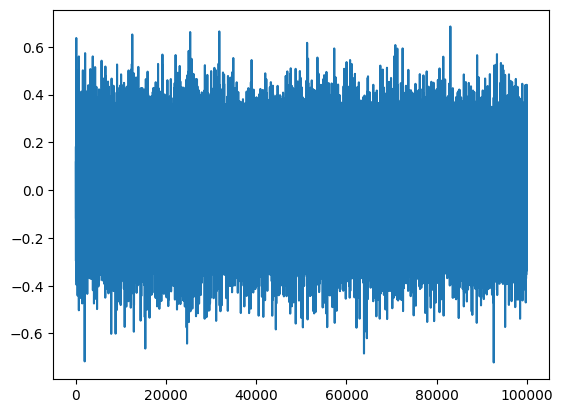

In [120]:
plt.plot(Mu)

In [32]:
Mu,X = mu_MAD_only(10000,101,1)

100%|██████████| 10000/10000 [00:04<00:00, 2315.33it/s]


In [136]:
Mu = np.array(Mu).reshape(-1)

In [33]:
X = median_abs_deviation(X,axis=1)


array([1., 1., 1., ..., 1., 1., 1.])

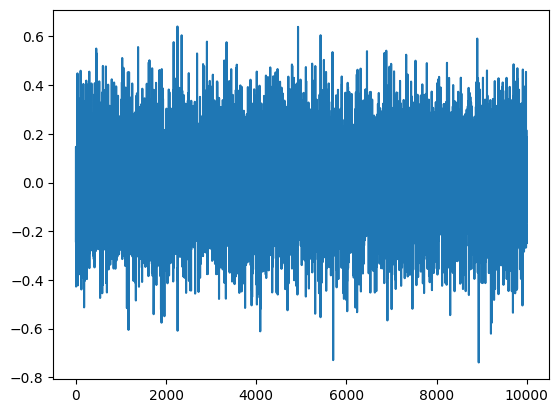

In [34]:
plt.plot(Mu)

## Gibbs

In [139]:
N

1001

In [154]:
MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(100000,101,0,1,List_X = True,verbose=True)


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [02:51<00:00, 582.82it/s]

Acceptation rates MH : loc = 70.12% 


In [135]:
Mu[:10000].reshape(-1)

AttributeError: 'list' object has no attribute 'reshape'

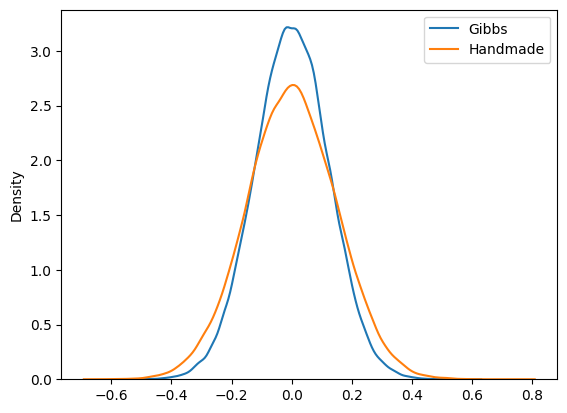

In [155]:
sns.kdeplot(MCMC_norm["chains"]["loc"],label="Gibbs")
sns.kdeplot(Mu,label="Handmade")
plt.legend()

## ABC

In [116]:
def ABC_Model_Paper_MAD(T,N,MAD,eps=.01):
    eta_obs = MAD
    mean = np.random.normal(0,2,T)
    std = 1
    y_norm = norm(loc = mean[:T//2],scale = std).rvs([N,T//2]).T
    y_laplace =laplace(loc = mean[T//2:], scale = std/np.sqrt(2)).rvs([N,T//2]).T
    y = np.concatenate([y_norm,y_laplace],axis=0)
    eta_sim = np.array(median_abs_deviation(y,axis=1))
    dist = (eta_obs-eta_sim)**2
    epsilon = np.quantile(dist,eps)
    idx = np.where(dist<epsilon)[0]
    model1 = len(idx[idx<T//2])
    model2 = len(idx[idx>=T//2])
    print("Model1: {:.2%}, Model2: {:.2%}".format(model1/len(idx),model2/len(idx)))
    if model2 == 0:
        BF = np.inf
    else:
        BF = model1/model2    
    return {"Y":y,"eta_sim":eta_sim,"dist":dist,"BF":BF,"Proba1": model1/len(idx)}
        

In [115]:
abc = ABC_Model_Paper_MAD(1000000,11,1,eps=.0001)

Model1: 75.00%, Model2: 25.00%


# Import Data

In [15]:
import pandas as pd
ABC_11 = pd.read_csv('./data/ABC_11.csv')
ABC_101 = pd.read_csv('./data/ABC_101.csv')
ABC_1001 = pd.read_csv('./data/ABC_1001.csv')
Bridge_11 = pd.read_csv('./data/Bridge_11.csv')
Bridge_101 = pd.read_csv('./data/Bridge_101.csv')
Bridge_1001 = pd.read_csv('./data/Bridge_1001.csv')
logBridge_11 = pd.read_csv('./data/logBridge_11.csv')
logBridge_101 = pd.read_csv('./data/logBridge_101.csv')
logBridge_1001 = pd.read_csv('./data/logBridge_1001.csv')


In [20]:
ABC_11


,Normal,Laplace,Cauchy
0,0.694915,0.818182,1.702703
1,2.225806,0.639344,3.545455
2,1.127660,0.538462,2.333333
3,0.265823,0.851852,2.333333
4,1.173913,1.380952,2.030303
...,...,...,...
95,1.857143,0.851852,2.571429
96,1.857143,1.702703,2.225806
97,1.702703,0.587302,4.555556
98,0.666667,3.347826,2.225806


## Comparison ABC

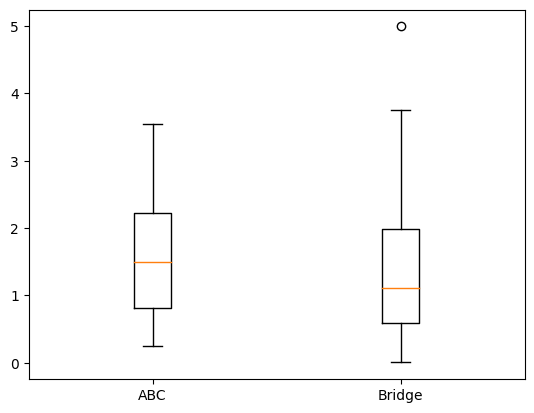

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb408f1ee10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb408f1e810>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb3f8558790>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb400cc2290>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb400cc2990>,
 'means': []}

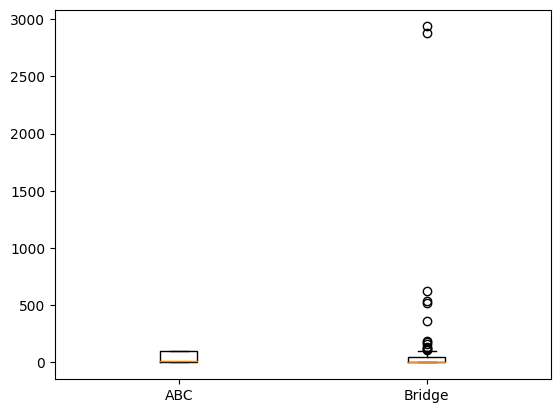

In [45]:
abc_norm=np.array(ABC_11.iloc[:,0])
bridge_norm = np.array(Bridge_11.iloc[:,0])
plt.boxplot([abc_norm,bridge_norm],labels=["ABC","Bridge"])
plt.show()
abc_norm = np.array(ABC_101.iloc[:,0])
bridge_norm = np.array(Bridge_101.iloc[:,0])
plt.boxplot([abc_norm,bridge_norm],labels=["ABC","Bridge"])


# P(M_1) when N grows

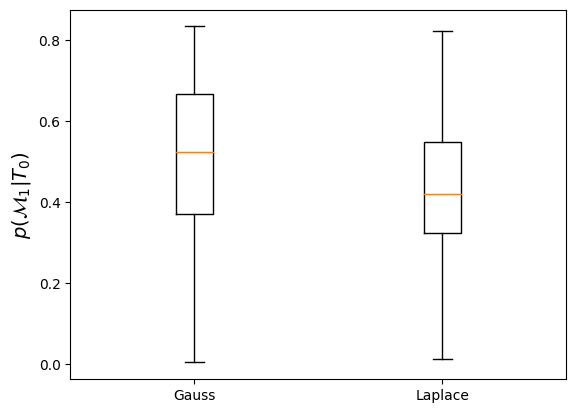

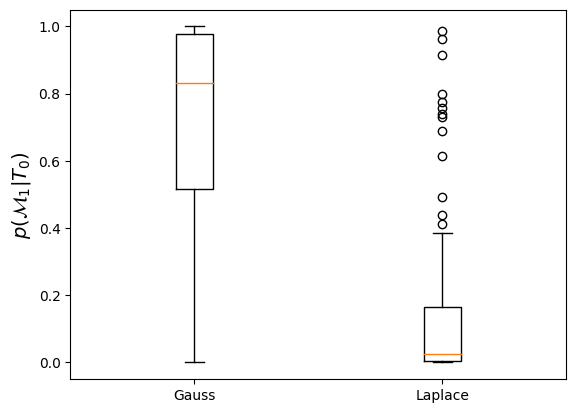

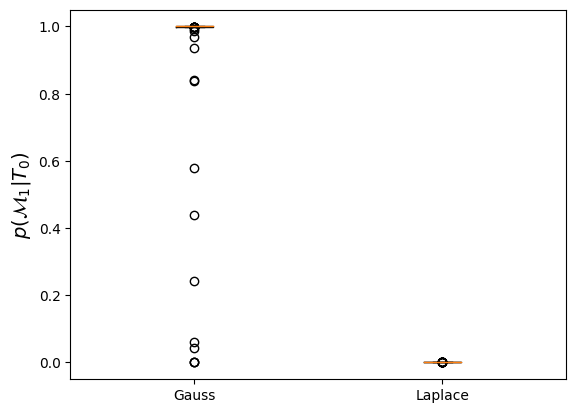

In [60]:
bridge_norm1 = np.array(Bridge_11.iloc[:,0])
bridge_norm2 = np.array(Bridge_101.iloc[:,0])
bridge_norm3 = np.array(Bridge_1001.iloc[:,0])

bridge_lp1 = np.array(Bridge_11.iloc[:,1])
bridge_lp2 = np.array(Bridge_101.iloc[:,1])
bridge_lp3 = np.array(Bridge_1001.iloc[:,1])

plt.boxplot([bridge_norm1/(1+bridge_norm1),bridge_lp1/(1+bridge_lp1)],labels=["Gauss","Laplace"]);
plt.ylabel("$p(\mathcal{M}_1|T_0)$",fontsize=14)
plt.show()

plt.boxplot([bridge_norm2/(1+bridge_norm2),bridge_lp2/(1+bridge_lp2)],labels=["Gauss","Laplace"]);
plt.ylabel("$p(\mathcal{M}_1|T_0)$",fontsize=14)
plt.show()

plt.boxplot([bridge_norm3/(1+bridge_norm3),bridge_lp3/(1+bridge_lp3)],labels=["Gauss","Laplace"]);
plt.ylabel("$p(\mathcal{M}_1|T_0)$",fontsize=14)
plt.show()


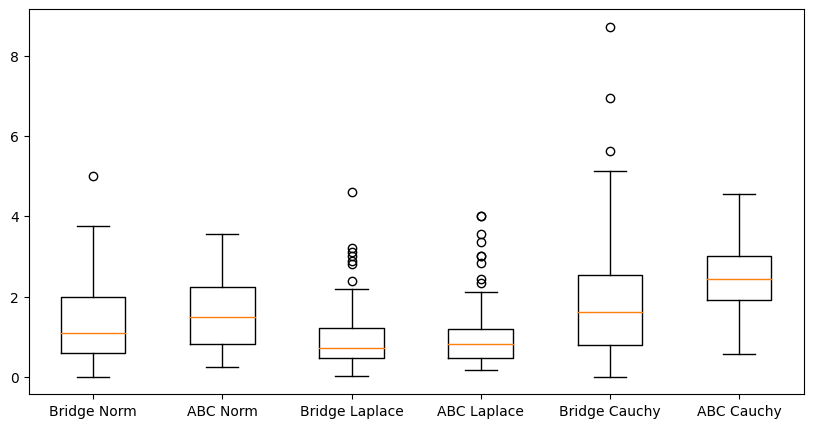

In [32]:
abc_norm=np.array(ABC_11.iloc[:,0])
abc_lp = np.array(ABC_11.iloc[:,1])
abc_cauchy = np.array(ABC_11.iloc[:,2])
bridge_norm = np.array(Bridge_11.iloc[:,0])
bridge_lp = np.array(Bridge_11.iloc[:,1])
bridge_cauchy = np.array(Bridge_11.iloc[:,2])
plt.figure(figsize=(10,5))
plt.boxplot([bridge_norm,abc_norm,bridge_lp,abc_lp,bridge_cauchy,abc_cauchy],labels=["Bridge Norm","ABC Norm","Bridge Laplace","ABC Laplace","Bridge Cauchy","ABC Cauchy"],widths=.5);

(-10.0, 200.0)

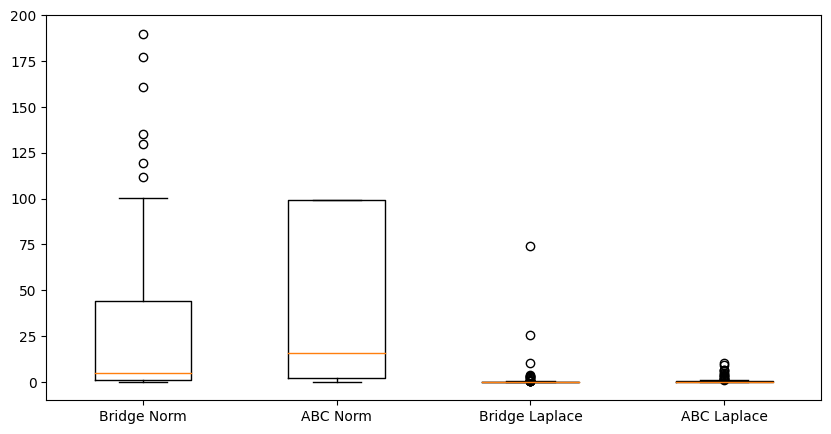

In [37]:
abc_norm=np.array(ABC_101.iloc[:,0])
abc_lp = np.array(ABC_101.iloc[:,1])
abc_cauchy = np.array(ABC_101.iloc[:,2])
bridge_norm = np.array(Bridge_101.iloc[:,0])
bridge_lp = np.array(Bridge_101.iloc[:,1])
bridge_cauchy = np.array(Bridge_101.iloc[:,2])
plt.figure(figsize=(10,5))
plt.boxplot([bridge_norm,abc_norm,bridge_lp,abc_lp],labels=["Bridge Norm","ABC Norm","Bridge Laplace","ABC Laplace"],widths=.5);
plt.ylim(-10,200)


[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf]


/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


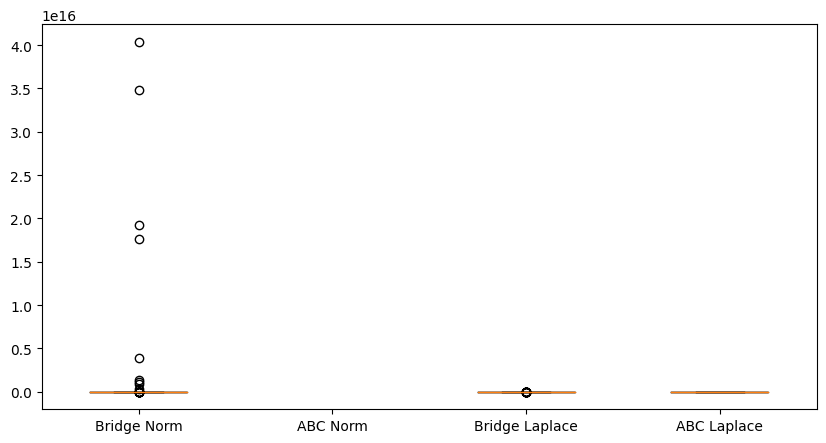

In [41]:
abc_norm=np.array(ABC_1001.iloc[:,0])


abc_lp = np.array(ABC_1001.iloc[:,1])
abc_cauchy = np.array(ABC_1001.iloc[:,2])
bridge_norm = np.array(Bridge_1001.iloc[:,0])

bridge_lp = np.array(Bridge_1001.iloc[:,1])

bridge_cauchy = np.array(Bridge_1001.iloc[:,2])
plt.figure(figsize=(10,5))
plt.boxplot([bridge_norm,abc_norm,bridge_lp,abc_lp],labels=["Bridge Norm","ABC Norm","Bridge Laplace","ABC Laplace"],widths=.5);
